In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime


In [2]:
df = pd.read_parquet("01_bbdd_think_tanks_no_stopwords.parquet")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    31647 non-null  int64         
 1   Think Tank            31647 non-null  object        
 2   Tipo de Think Tank    31647 non-null  object        
 3   Orientación Política  31647 non-null  object        
 4   Autor                 14186 non-null  object        
 5   Título                31647 non-null  object        
 6   Medio                 5811 non-null   object        
 7   Corpus                31647 non-null  object        
 8   Producto              18530 non-null  object        
 9   Enlace                31638 non-null  object        
 10  CorpusPDF             31647 non-null  object        
 11  FechaPublicacion      31477 non-null  datetime64[ns]
 12  Año                   31477 non-null  float64       
 13  Mes             

In [4]:
# Lista de hitos políticos con su descripción
hitos = [
    {"evento": "Inicio Estallido", "fecha": "2019-10-18"},
    {"evento": "Acuerdo por la Paz", "fecha": "2019-11-15"},
    {"evento": "Estado de Excepción COVID", "fecha": "2020-03-18"},
    {"evento": "Plebiscito Entrada", "fecha": "2020-10-27"},
    {"evento": "Elección Convencionales", "fecha": "2021-05-16"},
    {"evento": "Inicio Convención", "fecha": "2021-07-04"},
    {"evento": "Inicio Discusión Temática", "fecha": "2021-10-18"},
    {"evento": "Inicio Plenos", "fecha": "2022-02-15"},
    {"evento": "Comisiones finales", "fecha": "2022-04-29"},
    {"evento": "Entrega Proyecto Constitucional", "fecha": "2022-07-04"},
    {"evento": "Plebiscito Salida", "fecha": "2022-09-04"},
    {"evento": "Documento Bases", "fecha": "2022-12-12"},
    {"evento": "Lista Expertos", "fecha": "2023-01-24"},
    {"evento": "Inicio Comisión Experta", "fecha": "2023-03-06"},
    {"evento": "Elección Consejeros", "fecha": "2023-05-07"},
    {"evento": "Fin Anteproyecto", "fecha": "2023-05-30"},
    {"evento": "Inicio Consejo", "fecha": "2023-06-07"},
    {"evento": "Cierre Consejo", "fecha": "2023-11-07"},
    {"evento": "Plebiscito 2.0", "fecha": "2023-12-17"},
]

# Convertir fechas a datetime
for h in hitos:
    h["fecha"] = pd.to_datetime(h["fecha"])


In [5]:
def preparar_datos(df):
    df = df[df["FechaPublicacion"].notna()].copy()

    # Filtrar rango temporal
    df = df[
        (df["FechaPublicacion"] >= pd.to_datetime("2018-01-01")) &
        (df["FechaPublicacion"] <= pd.to_datetime("2023-12-31"))
    ]

    # Corregir etiquetas inconsistentes
    df["Tipo de Think Tank"] = df["Tipo de Think Tank"].replace({
        "Universidades": "Universidad"
    })

    # Crear variable de periodo mensual
    df["Periodo"] = df["FechaPublicacion"].dt.to_period("M")

    return df


In [6]:
def construir_intervalos(hitos):
    intervalos = []

    for i in range(len(hitos) - 1):
        h1 = hitos[i]
        h2 = hitos[i + 1]
        intervalo = {
            "evento_inicio": h1["evento"],
            "evento_fin": h2["evento"],
            "fecha_inicio": h1["fecha"],
            "fecha_fin": h2["fecha"],
            "centro": h1["fecha"] + (h2["fecha"] - h1["fecha"]) / 2
        }
        intervalos.append(intervalo)

    return intervalos


In [7]:
def construir_tabla_variaciones(df, think_tank, intervalos, ventana_meses=3):
    df_tt = df[df["Think Tank"] == think_tank].copy()
    df_tt.set_index("FechaPublicacion", inplace=True)

    resultados = []

    for inter in intervalos:
        fecha_inicio = inter["fecha_inicio"]
        fecha_fin = inter["fecha_fin"]
        intervalo_nombre = f'{inter["evento_inicio"]} → {inter["evento_fin"]}'

        pre = df_tt.loc[(df_tt.index >= fecha_inicio - pd.DateOffset(months=ventana_meses)) &
                        (df_tt.index < fecha_inicio)].shape[0]

        post = df_tt.loc[(df_tt.index >= fecha_inicio) &
                         (df_tt.index < fecha_fin)].shape[0]

        if pre > 0:
            var_pct = (post - pre) / pre * 100
        elif post == 0:
            var_pct = 0
        else:
            var_pct = None

        resultados.append({
            "Intervalo": intervalo_nombre,
            "Fecha inicio": fecha_inicio.date(),
            "Fecha fin": fecha_fin.date(),
            "N° pre": pre,
            "N° post": post,
            "Variación (%)": var_pct
        })

    return pd.DataFrame(resultados)


In [8]:
def estilo_variaciones(df_variaciones):
    df = df_variaciones.copy()

    idx_max = df["Variación (%)"].idxmax()
    idx_min = df["Variación (%)"].idxmin()

    def resaltar(val, index):
        color = ""
        if index == idx_max:
            color = "background-color: lightgreen"
        elif index == idx_min:
            color = "background-color: lightcoral"
        return color

    return df.style.apply(
        lambda col: [resaltar(v, i) if col.name == "Variación (%)" else "" for i, v in enumerate(col)],
        axis=0
    ).format({"Variación (%)": "{:+.1f}%"})


In [9]:
# Preparar tus datos (asegúrate de tener df cargado)
df_limpio = preparar_datos(df)

# Think Tank a analizar
think_tank = "Nodo XXI"

# Construcción de intervalos y cálculo de tabla
intervalos = construir_intervalos(hitos)
tabla_variaciones = construir_tabla_variaciones(df_limpio, think_tank, intervalos)

# Visualización estilizada
estilo_variaciones(tabla_variaciones)


In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def graficar_panel_completo(df, think_tank, intervalos, tabla_variaciones):
    df_tt = df[df["Think Tank"] == think_tank].copy()
    df_tt["Periodo"] = df_tt["FechaPublicacion"].dt.to_period("M")
    df_tt["Periodo_dt"] = df_tt["Periodo"].dt.to_timestamp()

    publicaciones = (
        df_tt.groupby("Periodo_dt").size()
        .rolling(window=3, min_periods=1)
        .mean()
        .reset_index(name="Rolling")
    )

    fig = plt.figure(constrained_layout=True, figsize=(16, 10))
    spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[2, 1], figure=fig)

    # Panel superior: gráfico
    ax1 = fig.add_subplot(spec[0])

    ax1.set_title(f"Densidad mensual de publicaciones — {think_tank}", fontsize=14)
    ax1.set_ylabel("Publicaciones")
    ax1.set_xlabel("Fecha")
    ax1.grid(True)
    ax1.set_xlim([pd.to_datetime("2018-01-01"), pd.to_datetime("2023-12-31")])

    # Mostrar total de publicaciones
    total_pub = df_tt.shape[0]
    ax1.text(
        pd.to_datetime("2018-01-01"),
        publicaciones["Rolling"].max() + 2,
        f"Total publicaciones en el período: {total_pub}",
        fontsize=10,
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8)
    )

    # Línea base completa (gris claro)
    ax1.plot(publicaciones["Periodo_dt"], publicaciones["Rolling"], color="lightgray", linewidth=1.5, zorder=0)

    # Superposición: línea segmentada por variaciones
    for i, inter in enumerate(intervalos):
        var = tabla_variaciones.loc[i, "Variación (%)"]
        color = "gray"
        if pd.notnull(var):
            if var > 0:
                color = "green"
            elif var < 0:
                color = "red"

        fecha_inicio = inter["fecha_inicio"]
        fecha_fin = inter["fecha_fin"]

        segmento = publicaciones[
            (publicaciones["Periodo_dt"] >= fecha_inicio) &
            (publicaciones["Periodo_dt"] <= fecha_fin)
        ]

        if not segmento.empty:
            ax1.plot(segmento["Periodo_dt"], segmento["Rolling"], color=color, linewidth=2.5, zorder=1)

        # Línea vertical punteada en fin de intervalo
        ax1.axvline(fecha_fin, color="black", linestyle="--", linewidth=0.8)

    # Panel inferior: tabla
    ax2 = fig.add_subplot(spec[1])
    ax2.axis("off")

    # Construir tabla visual
    cell_text = []
    for _, row in tabla_variaciones.iterrows():
        formatted = [
            row["Intervalo"],
            str(row["Fecha inicio"]),
            str(row["Fecha fin"]),
            str(row["N° pre"]),
            str(row["N° post"]),
            f"{row['Variación (%)']:+.1f}%" if pd.notnull(row["Variación (%)"]) else "—"
        ]
        cell_text.append(formatted)

    columnas = ["Intervalo", "Inicio", "Fin", "N° pre", "N° post", "Variación (%)"]
    table = ax2.table(cellText=cell_text, colLabels=columnas, cellLoc='center', loc='center')

    # Ajustes de tabla
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    table.auto_set_column_width(col=list(range(len(columnas))))

    # Resaltado con degradado
    max_var = tabla_variaciones["Variación (%)"].max()
    min_var = tabla_variaciones["Variación (%)"].min()

    for i, row in tabla_variaciones.iterrows():
        var = row["Variación (%)"]
        if pd.isnull(var):
            continue
        cell = table[i + 1, 5]
        if var > 0:
            intensidad = var / max_var if max_var != 0 else 0
            cell.set_facecolor((0.8 - 0.5 * intensidad, 1.0, 0.8 - 0.5 * intensidad))  # verde más oscuro
        elif var < 0:
            intensidad = abs(var / min_var) if min_var != 0 else 0
            cell.set_facecolor((1.0, 0.8 - 0.5 * intensidad, 0.8 - 0.5 * intensidad))  # rojo más oscuro

    plt.suptitle(f"Panel de análisis — {think_tank}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


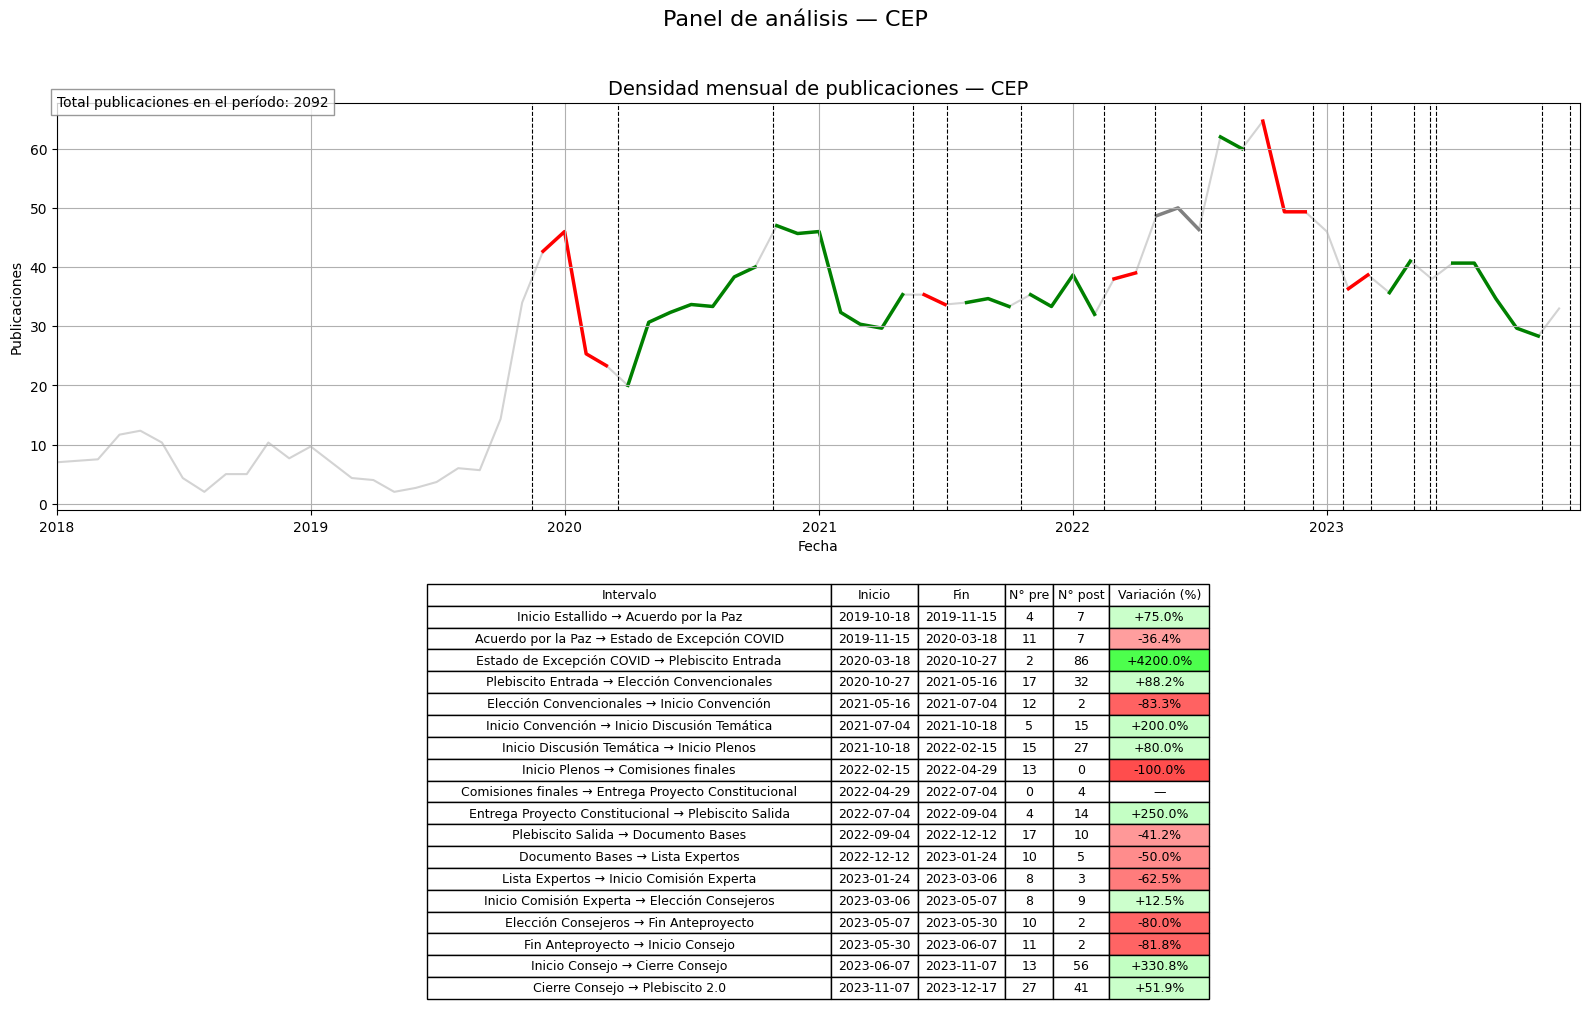

In [11]:
graficar_panel_completo(df_limpio, think_tank="CEP", intervalos=intervalos, tabla_variaciones=tabla_variaciones)



Procesando: LyD


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


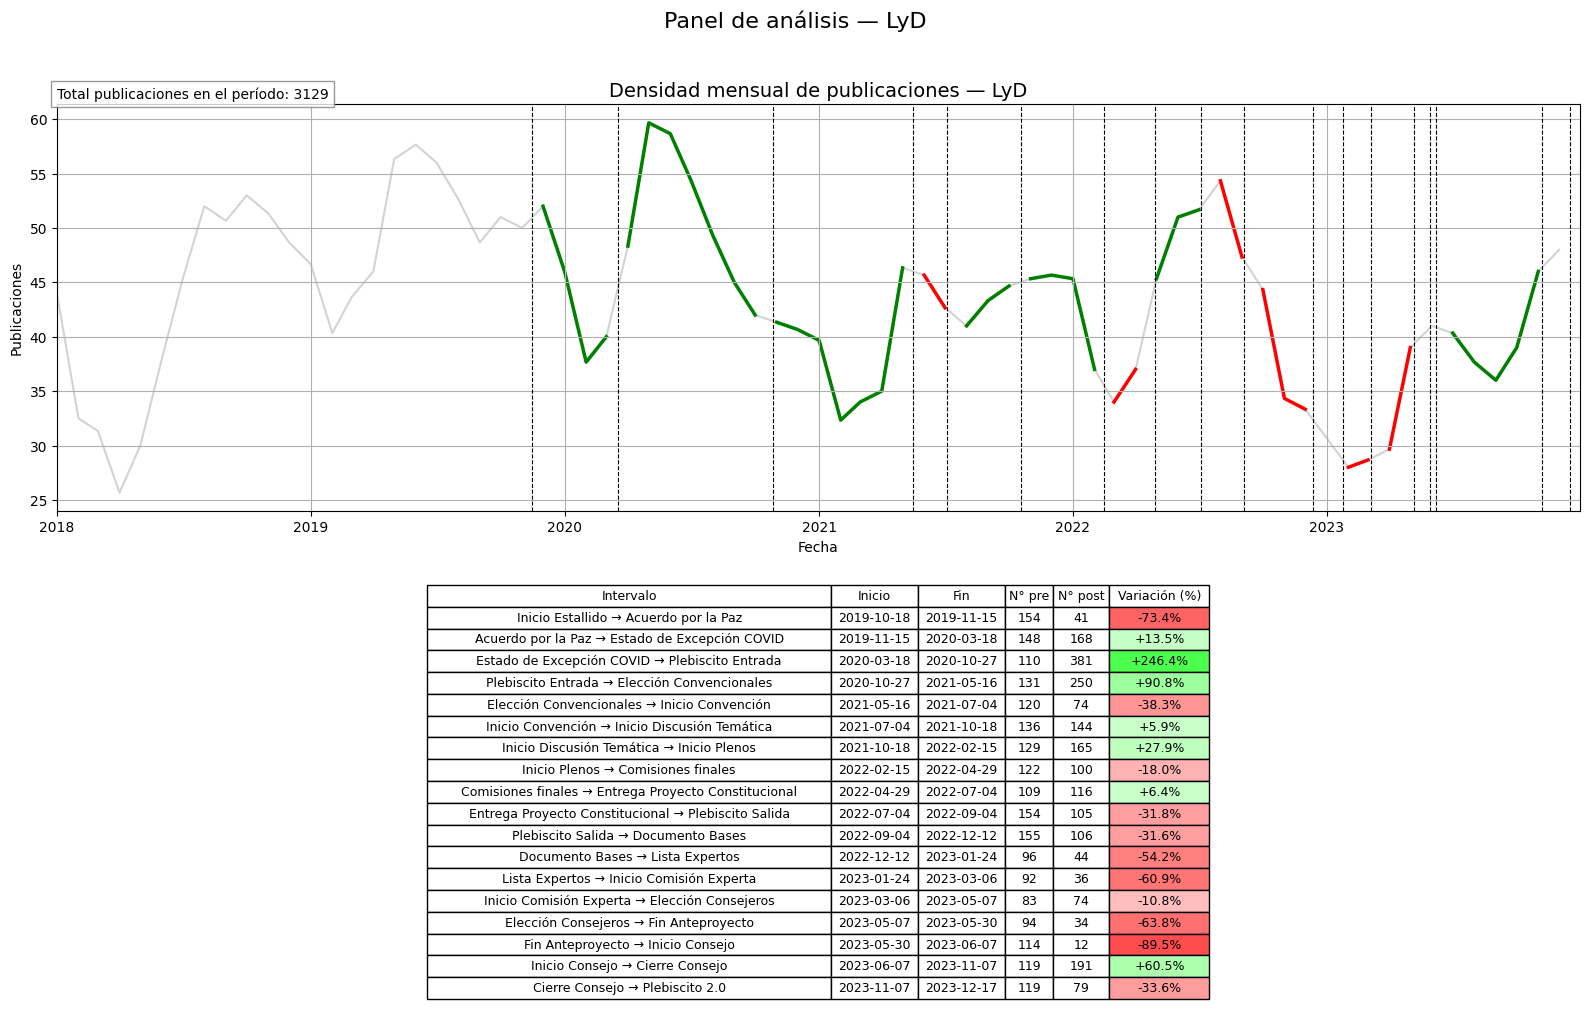


Procesando: CEP


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


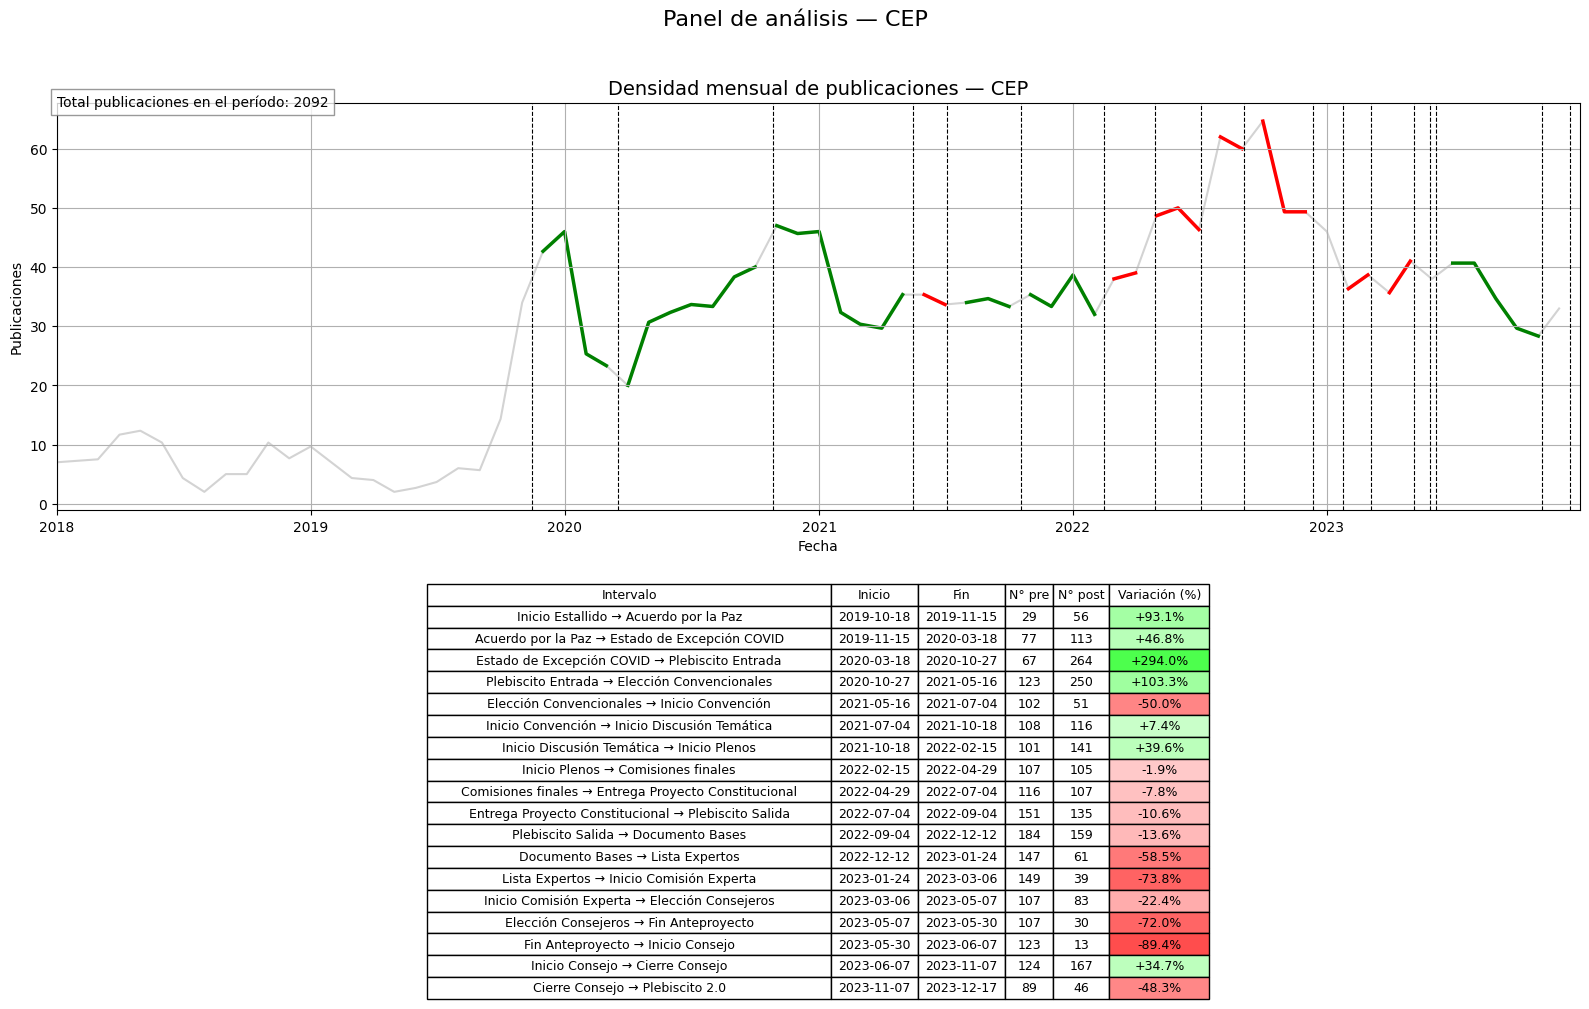


Procesando: Chile 21


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


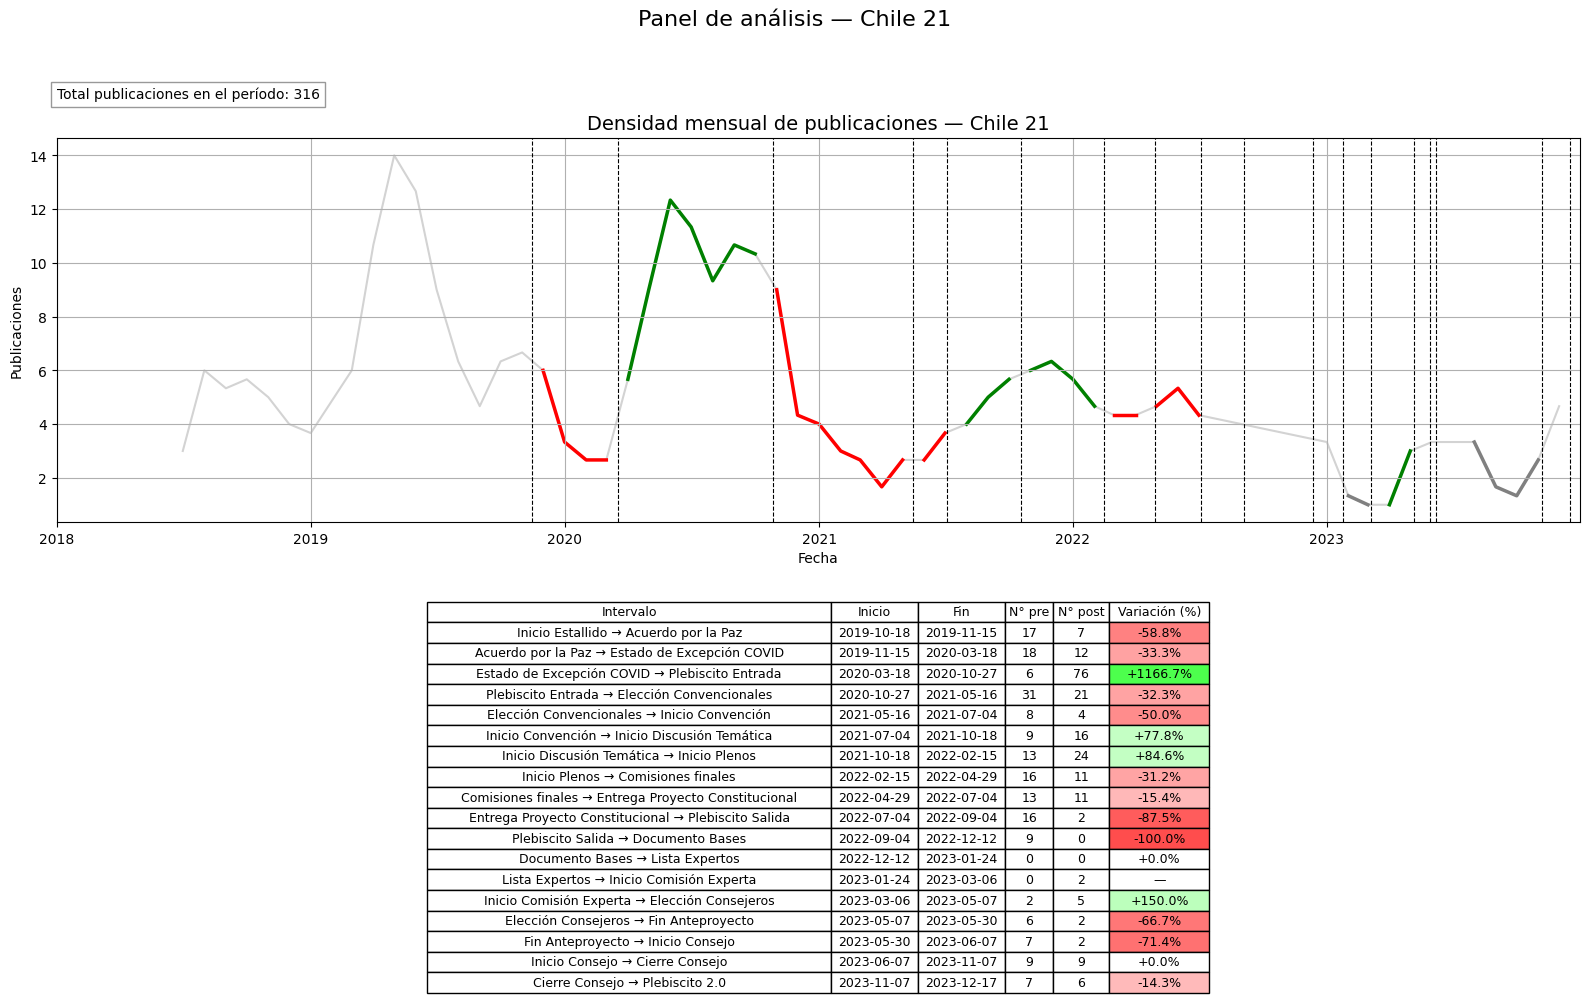


Procesando: Espacio Público


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


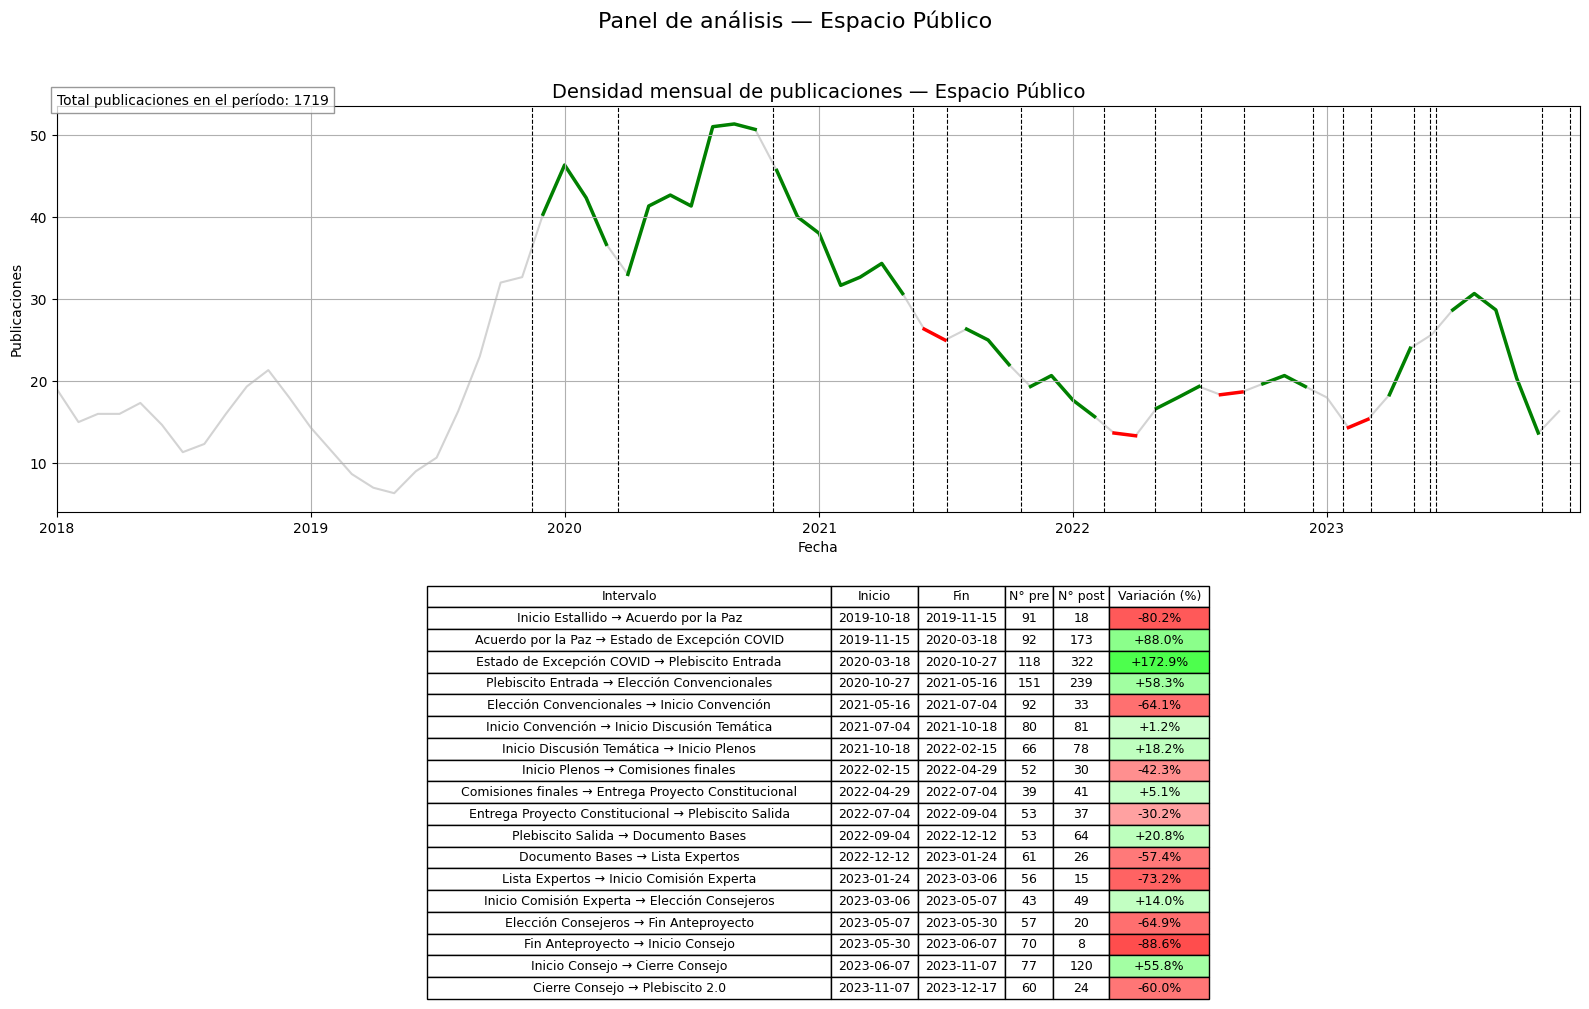


Procesando: Fundación Sol


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


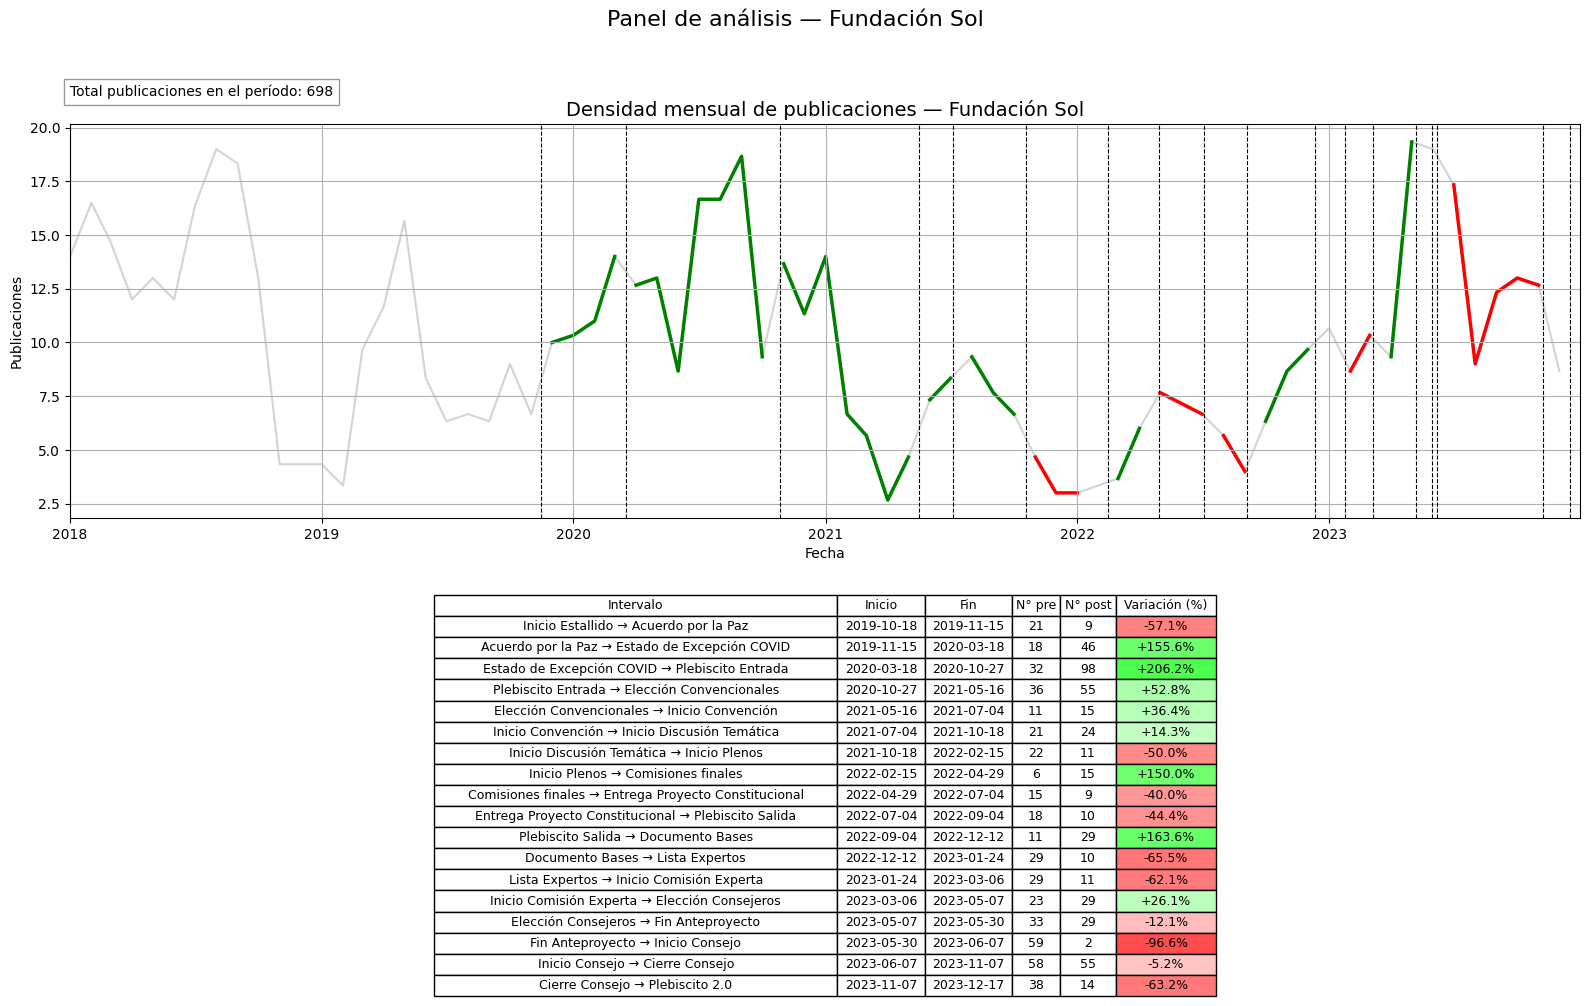


Procesando: IES


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


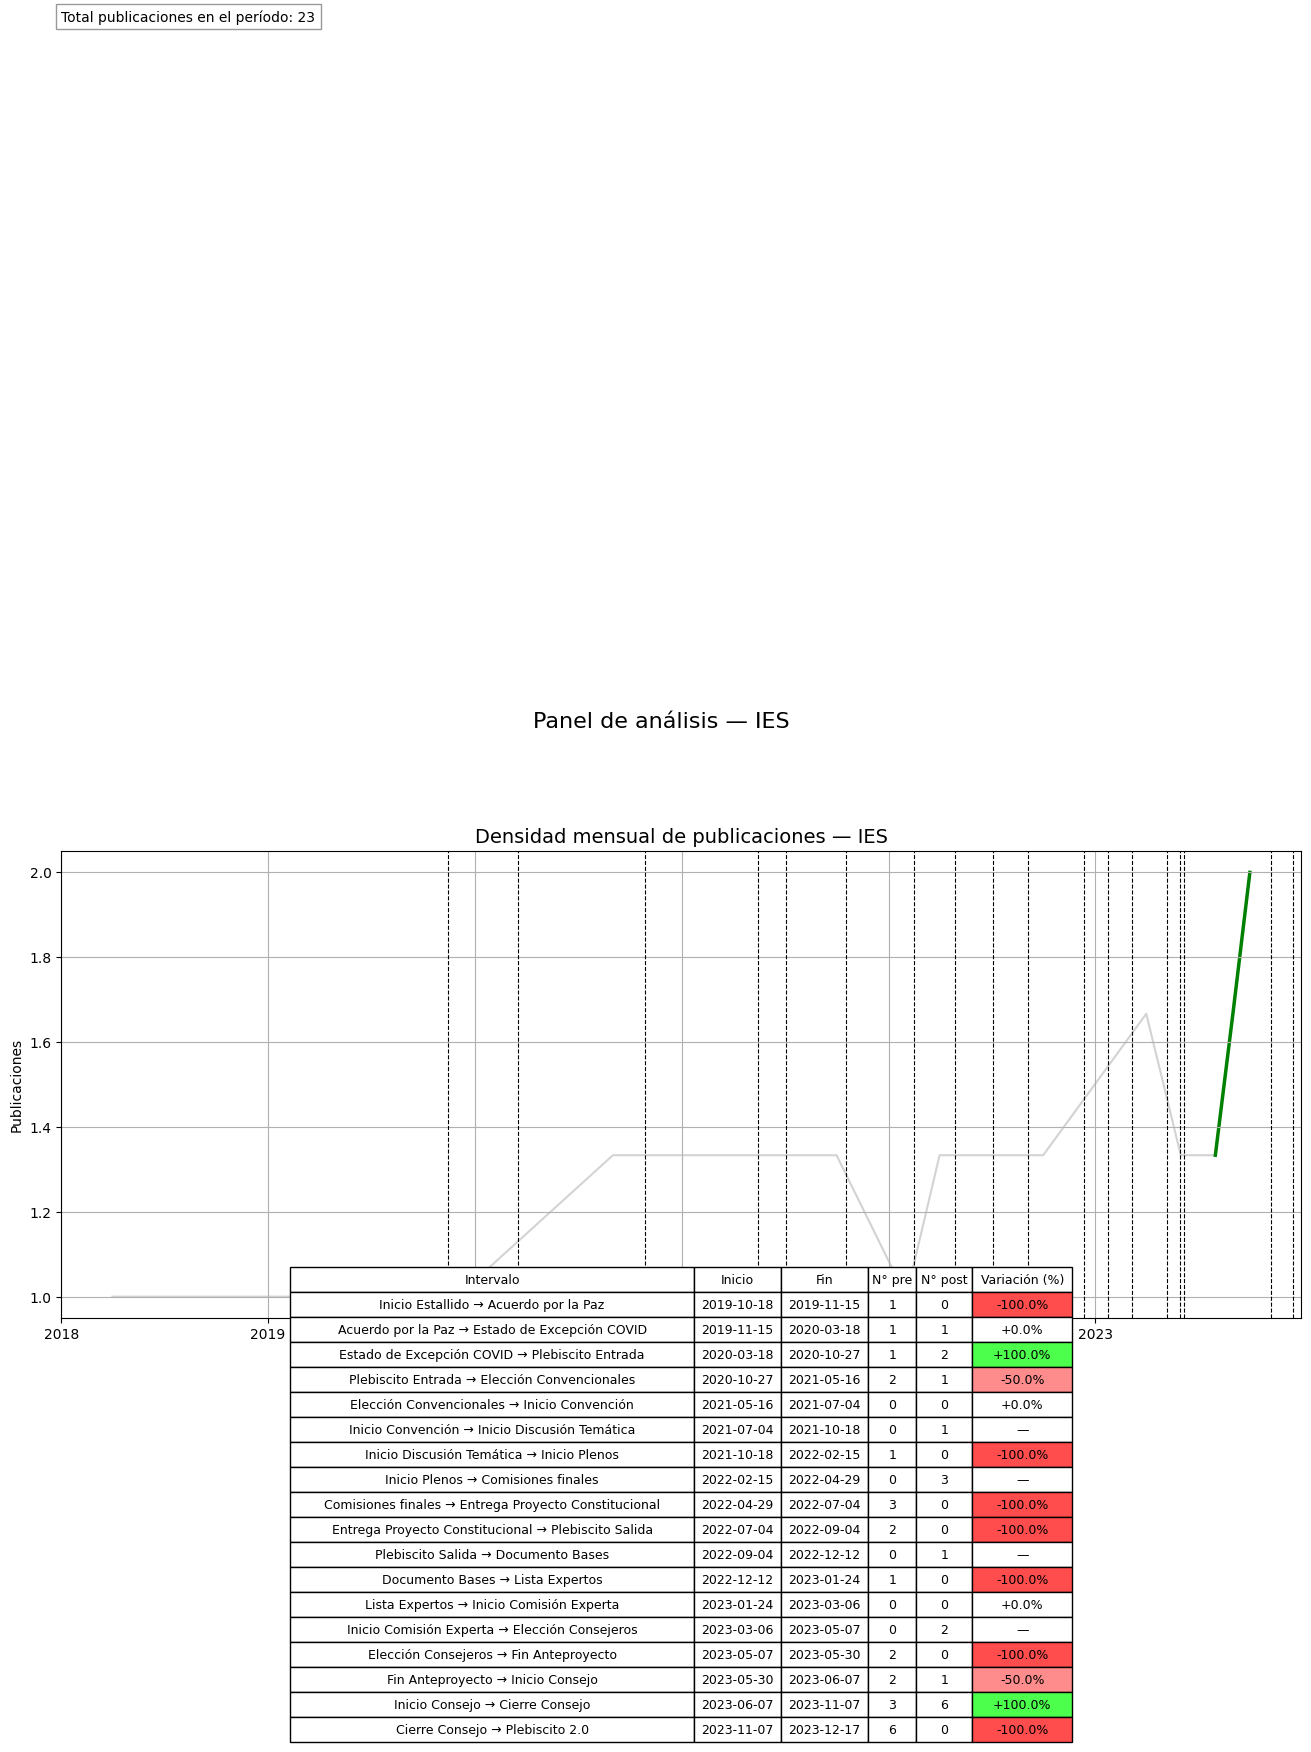


Procesando: Nodo XXI


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


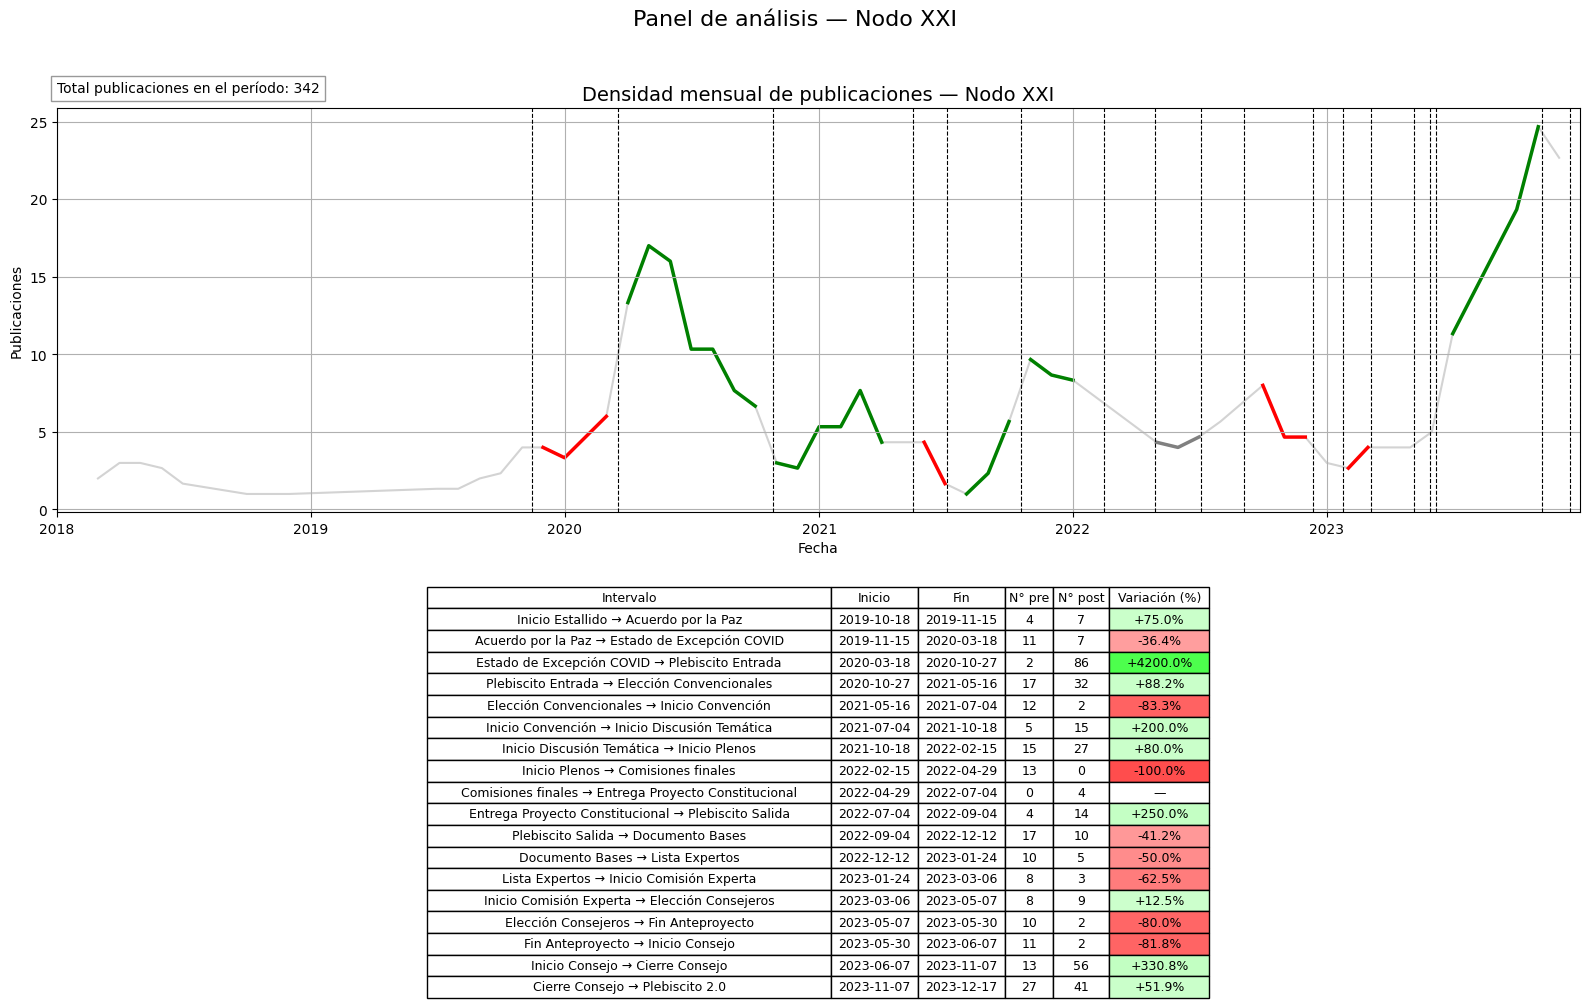


Procesando: OPES


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


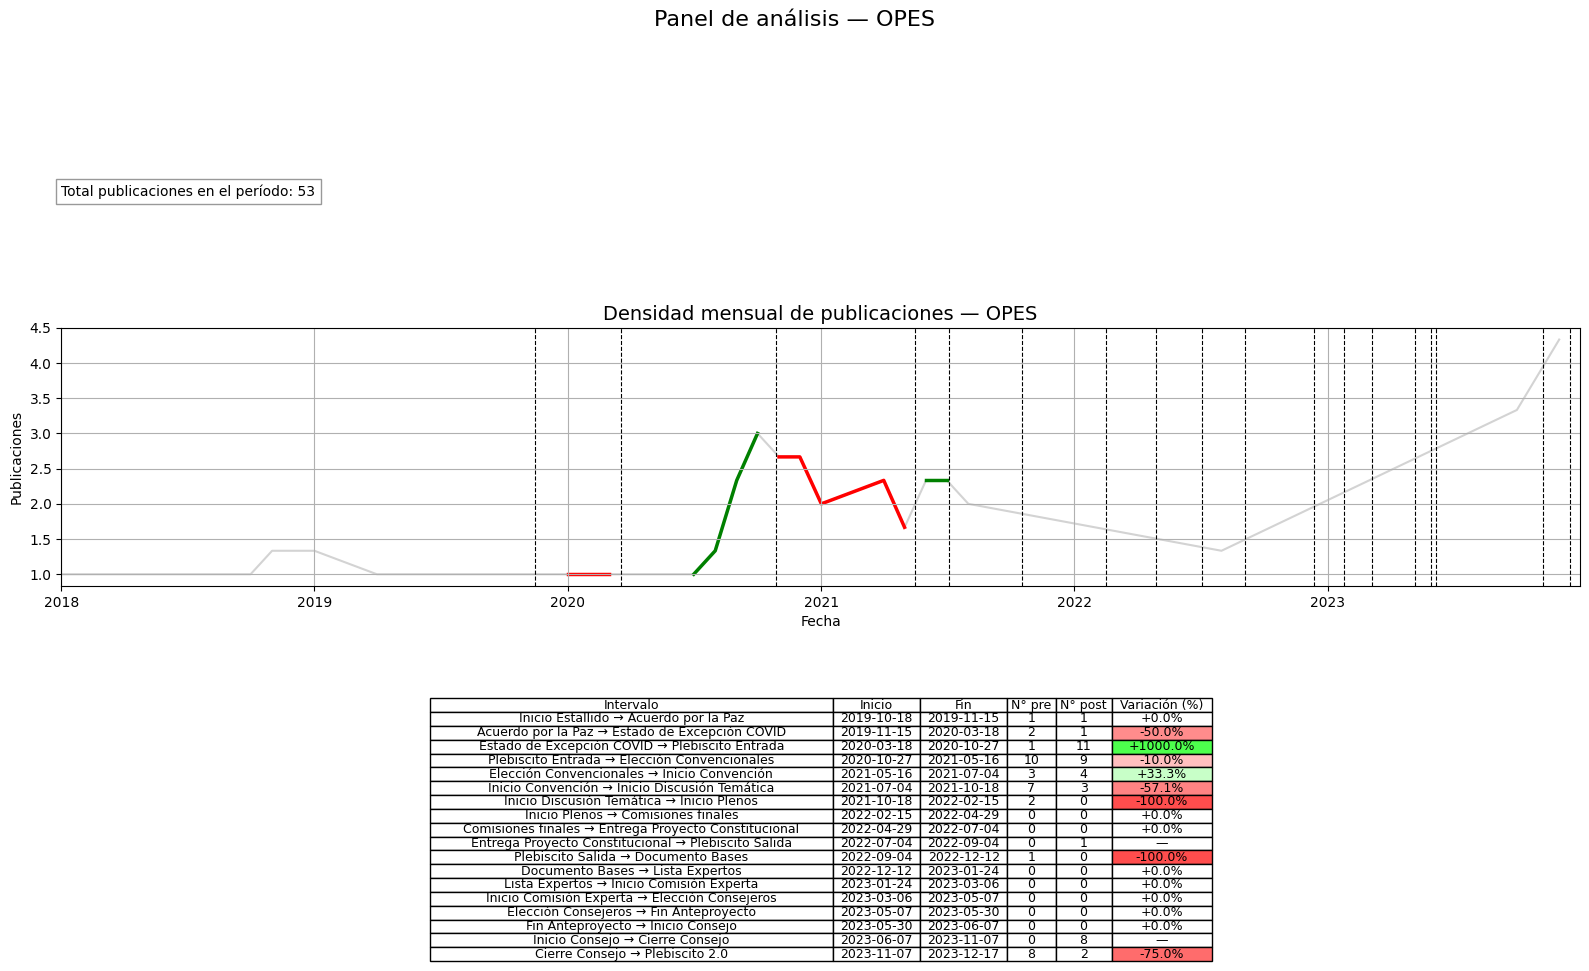


Procesando: Instituto Igualdad


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


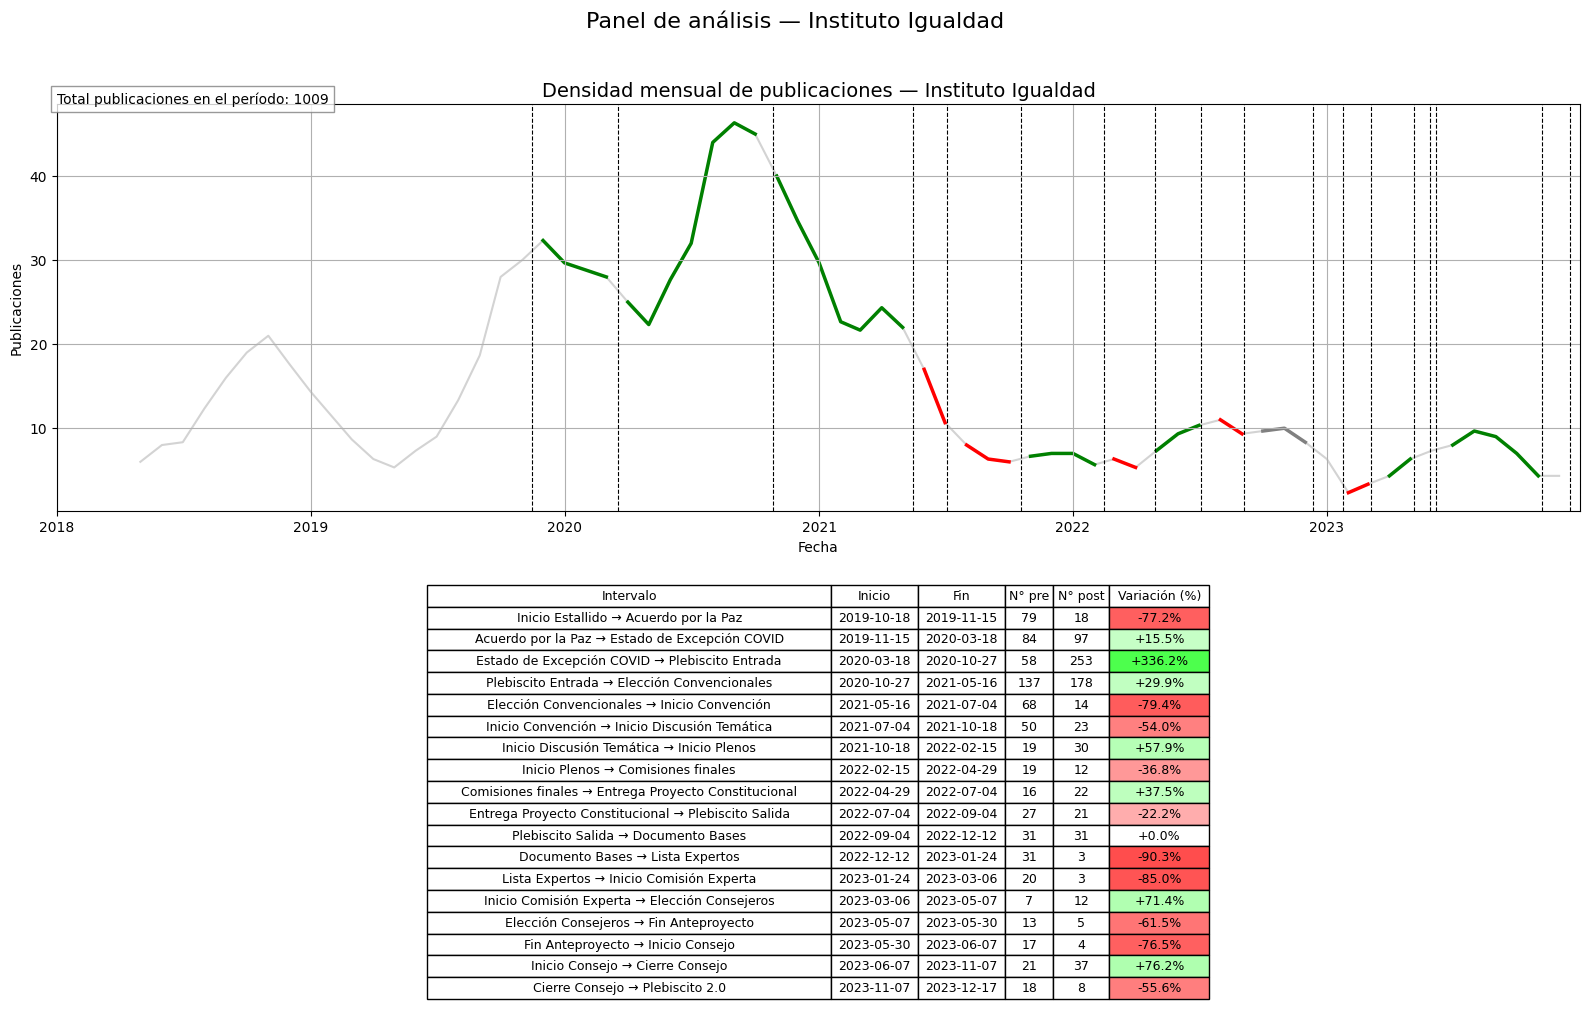


Procesando: ICAL


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


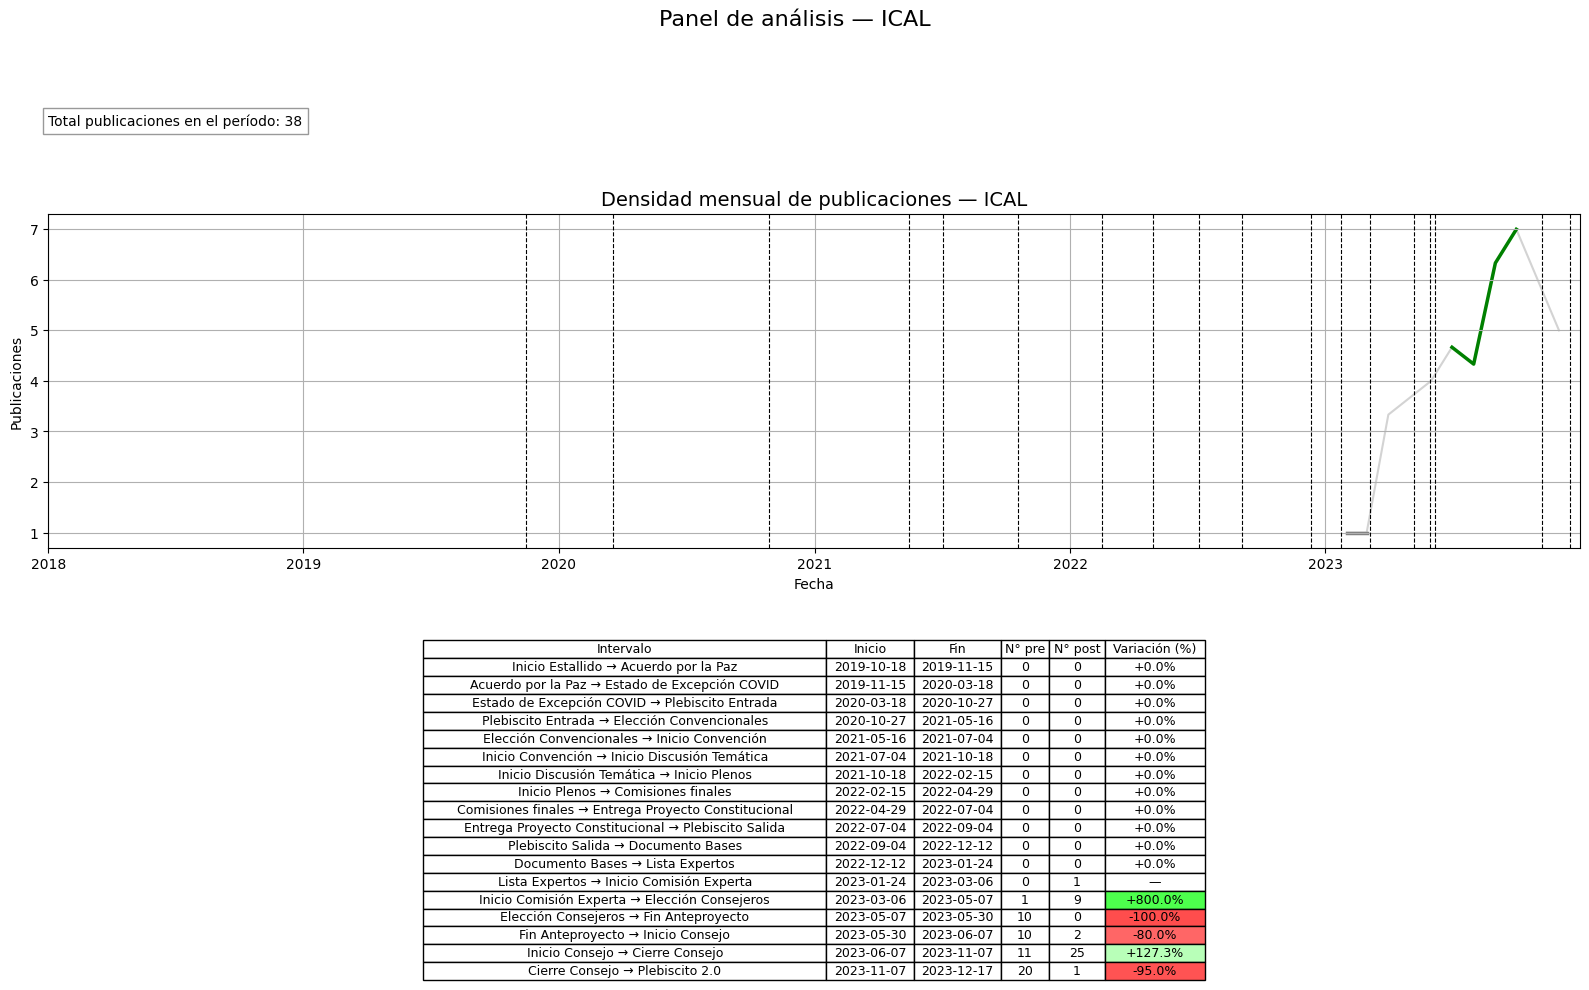


Procesando: Horizonte Ciudadano


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


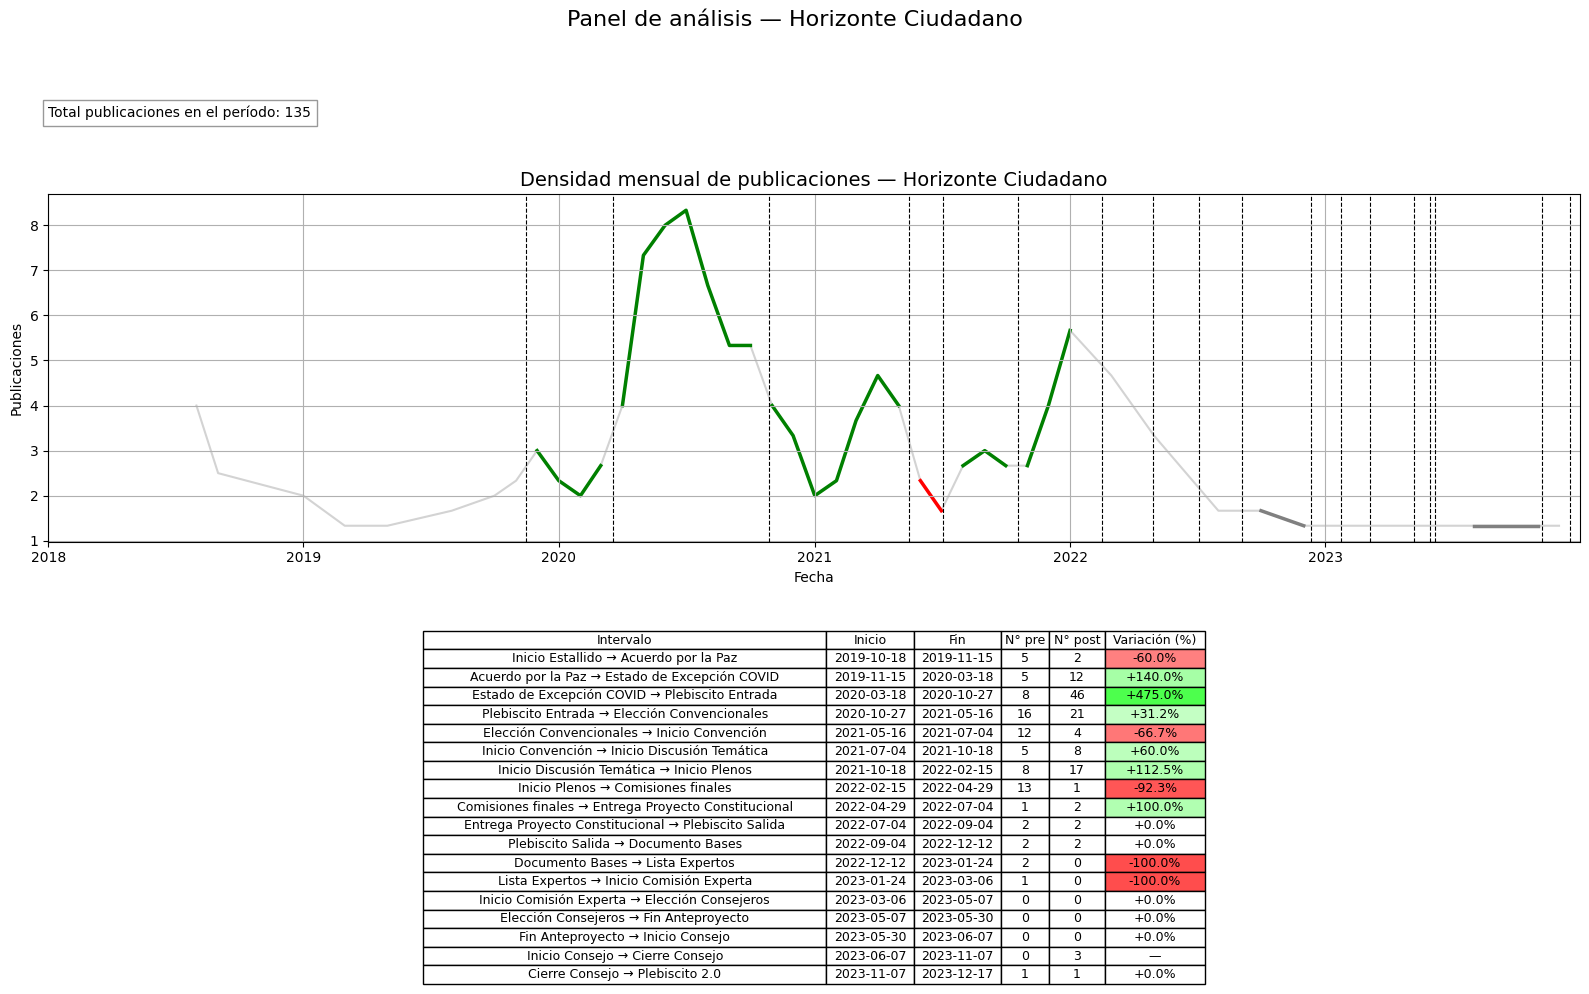


Procesando: CED


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


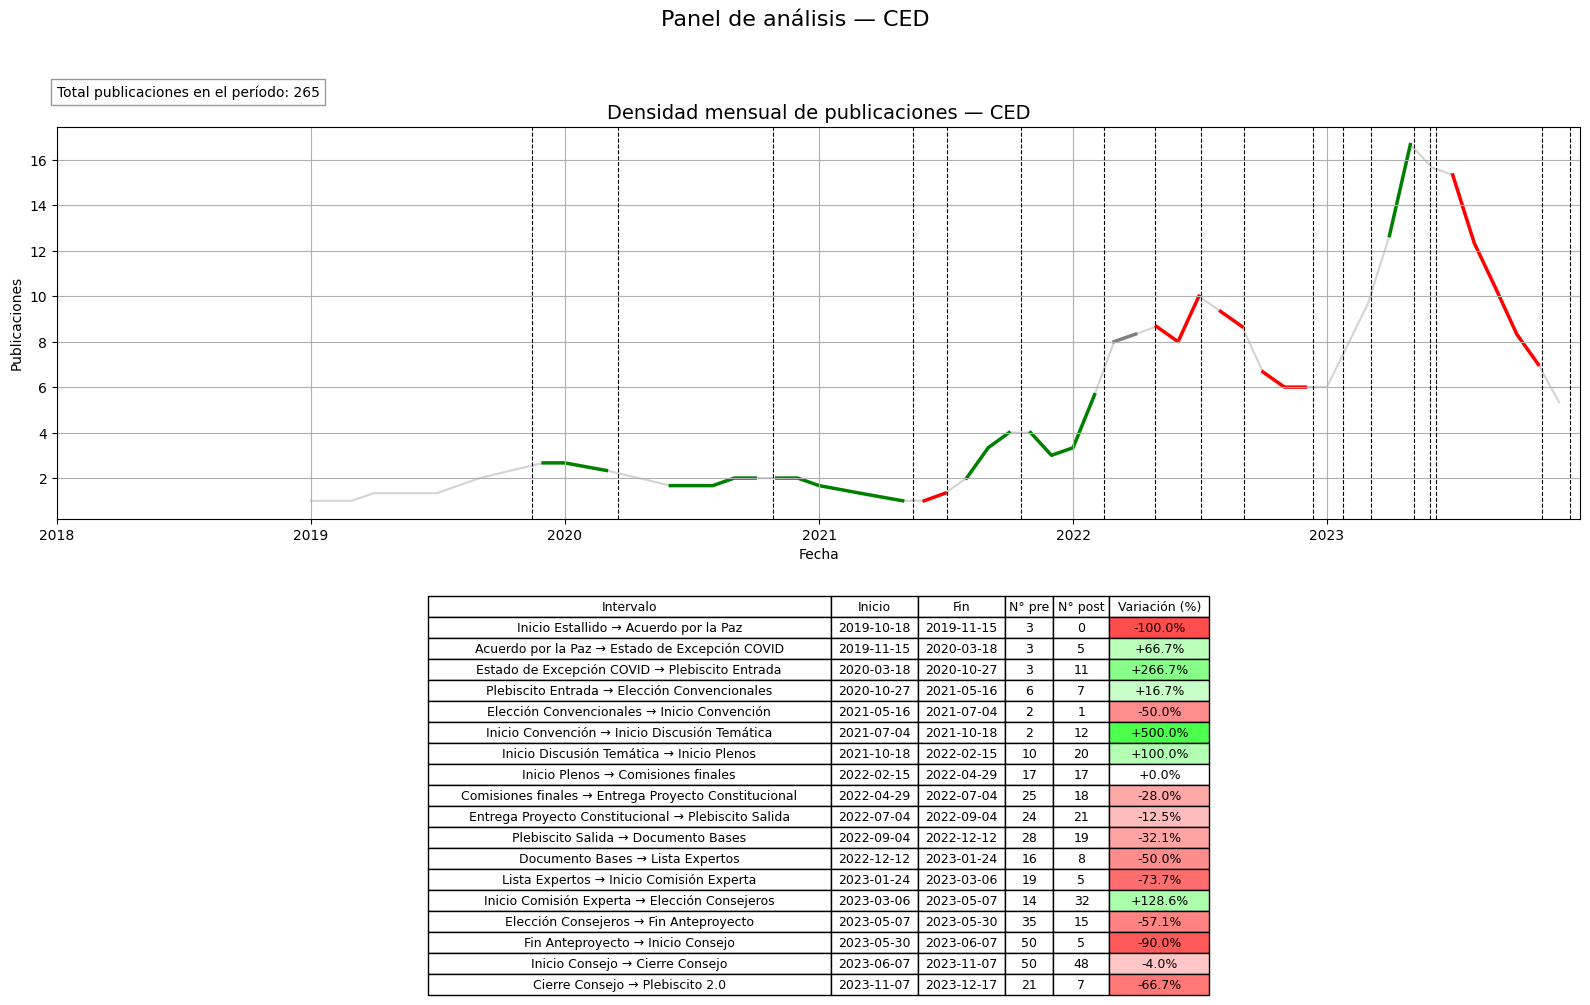


Procesando: CDC


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


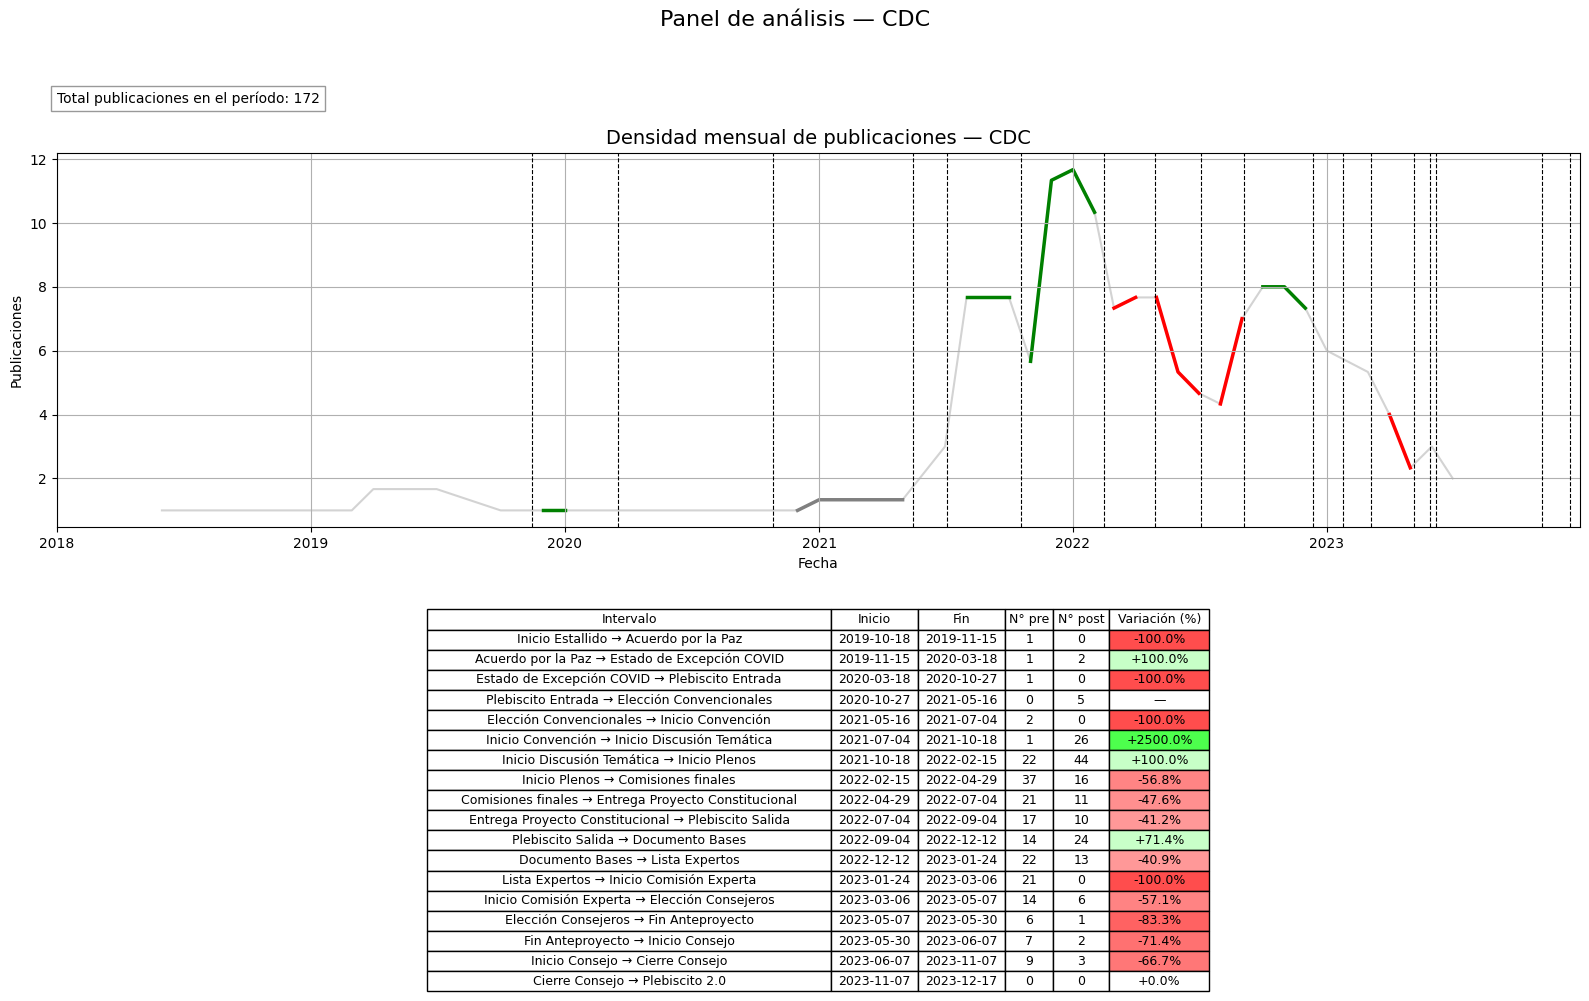


Procesando: Casa Común


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


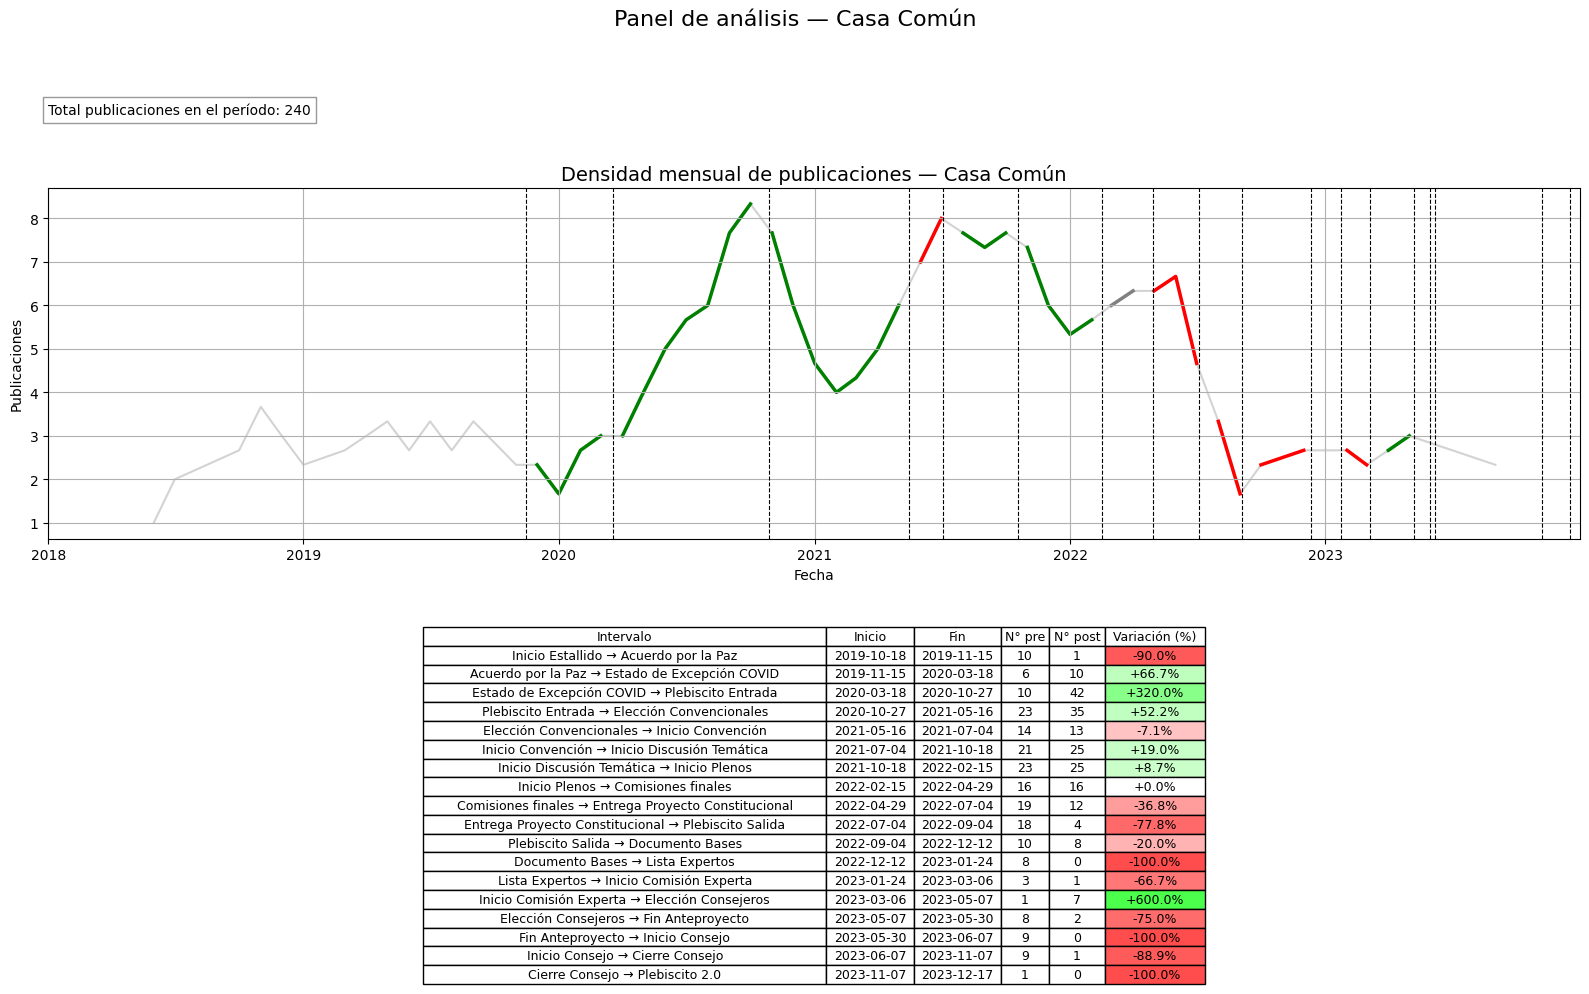


Procesando: Signos Uandes


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


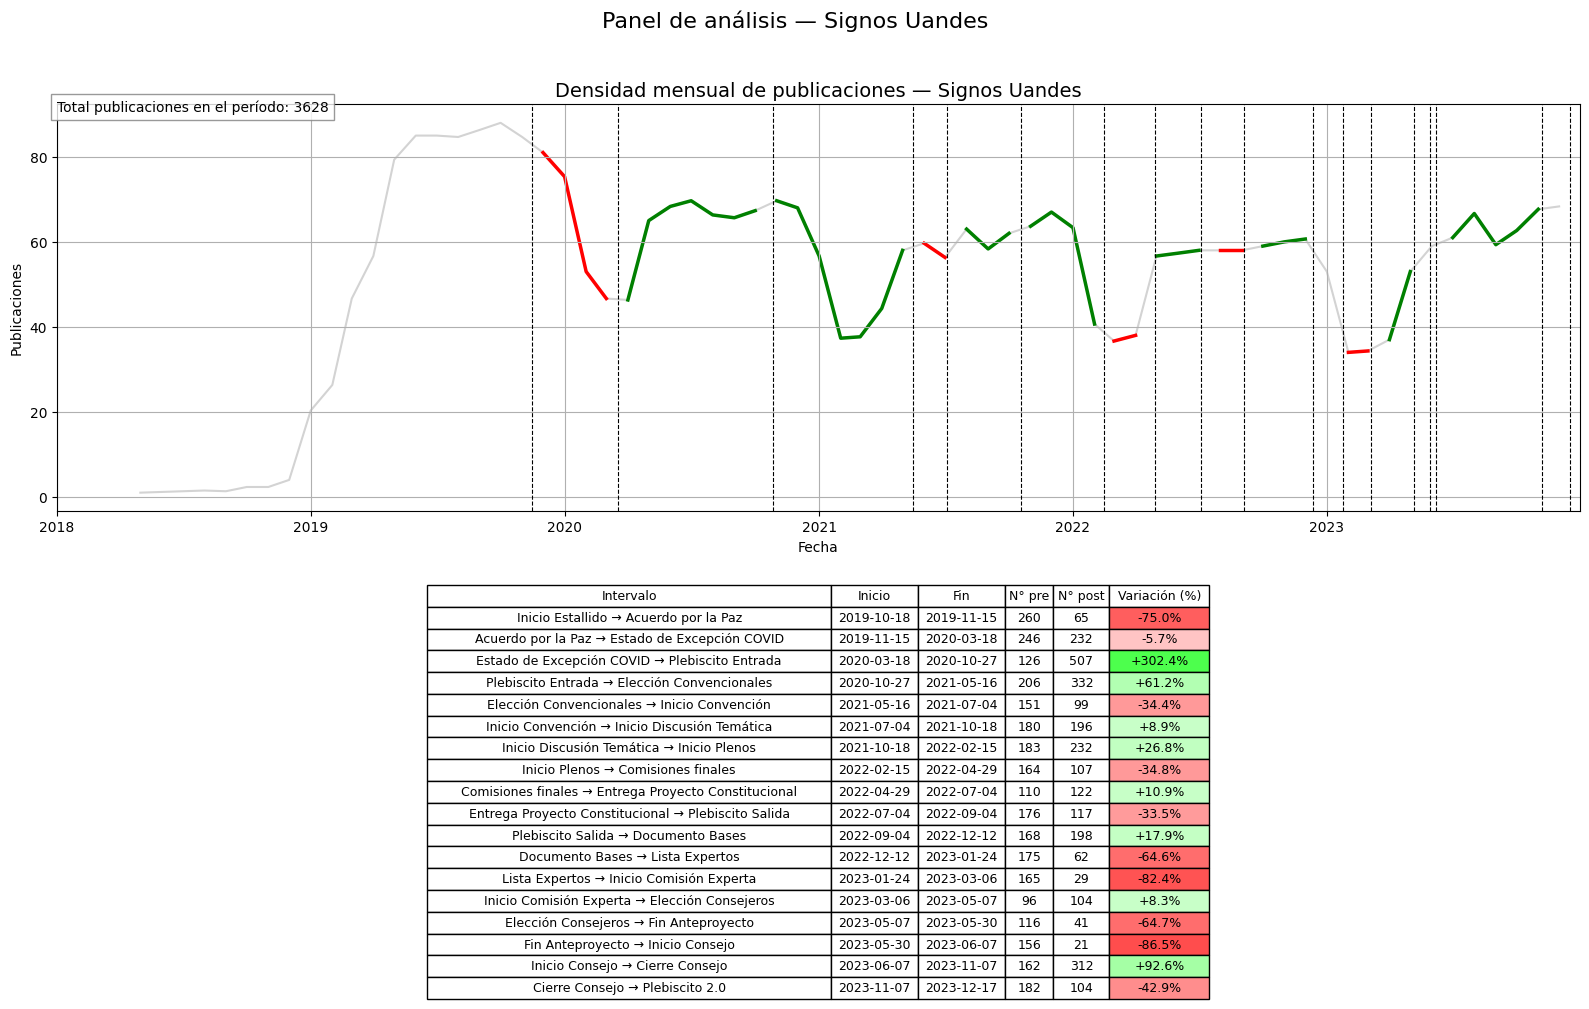


Procesando: Instituto Res Pública


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


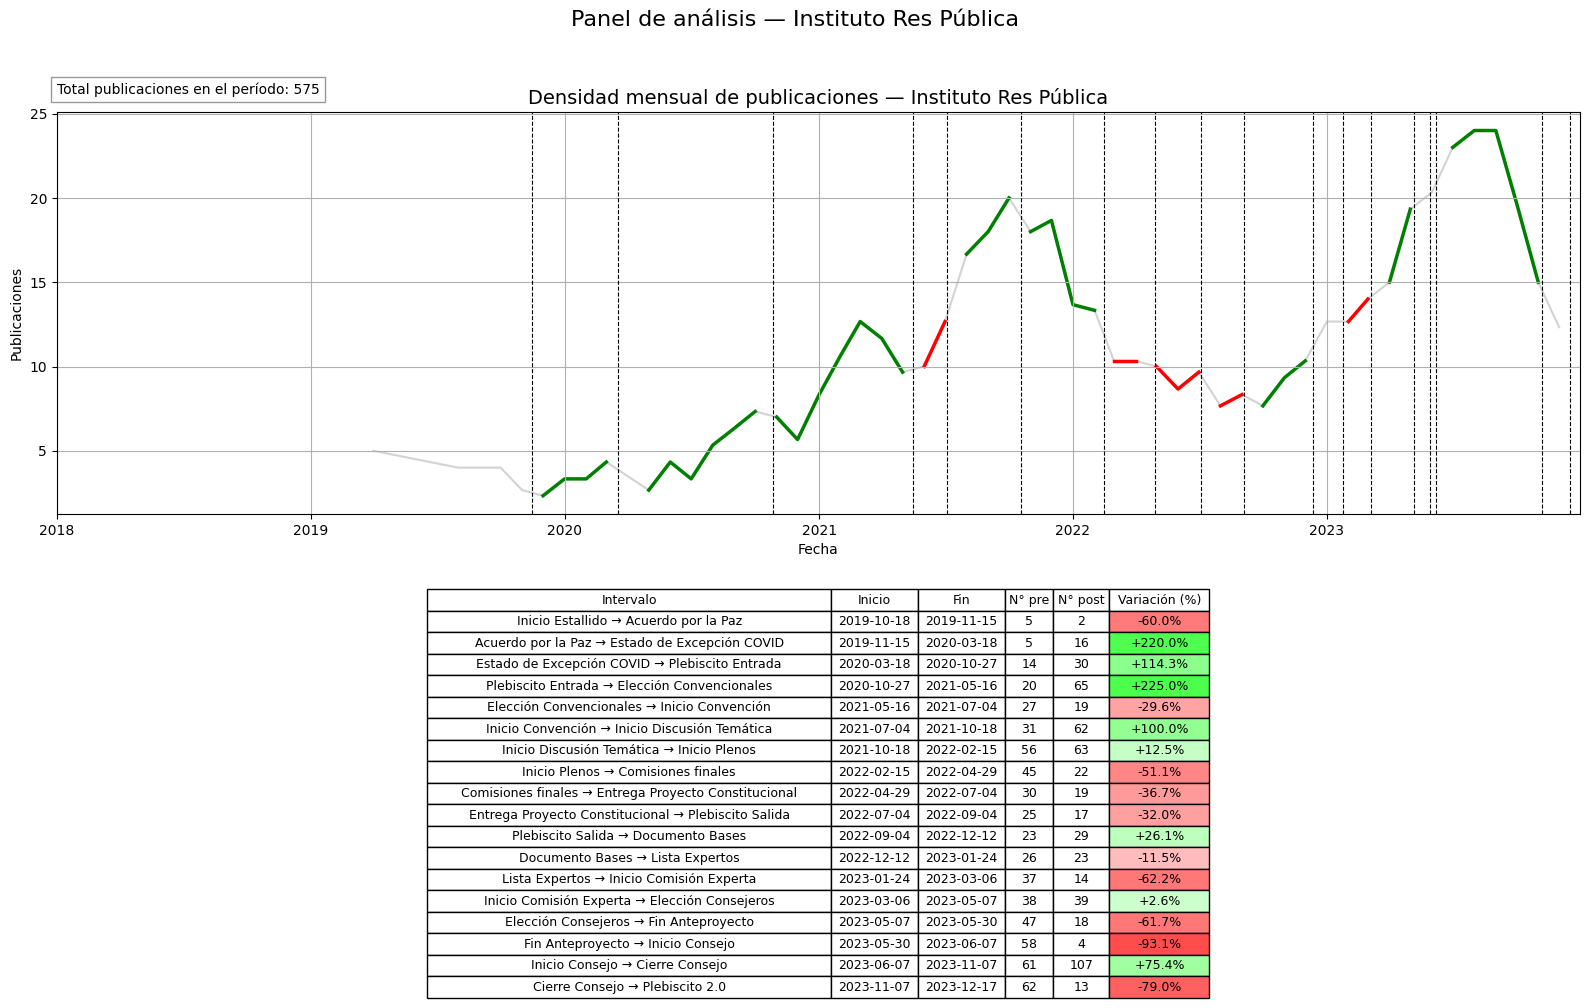


Procesando: Pivotes


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


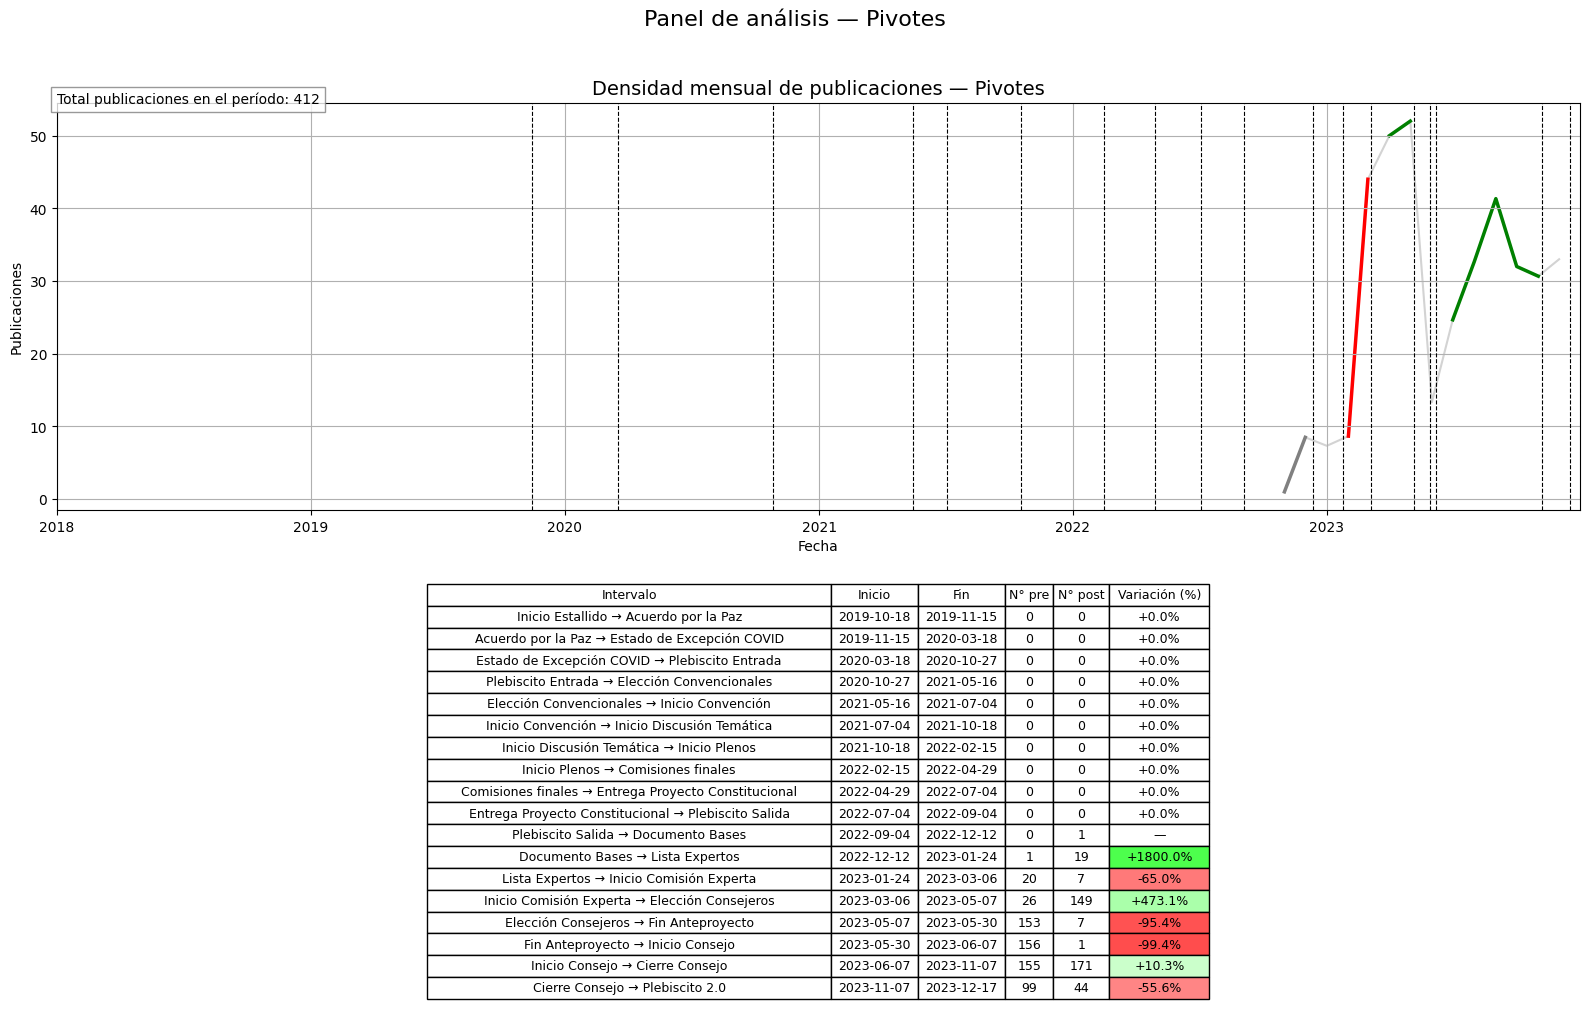


Procesando: Instituto Libertad


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


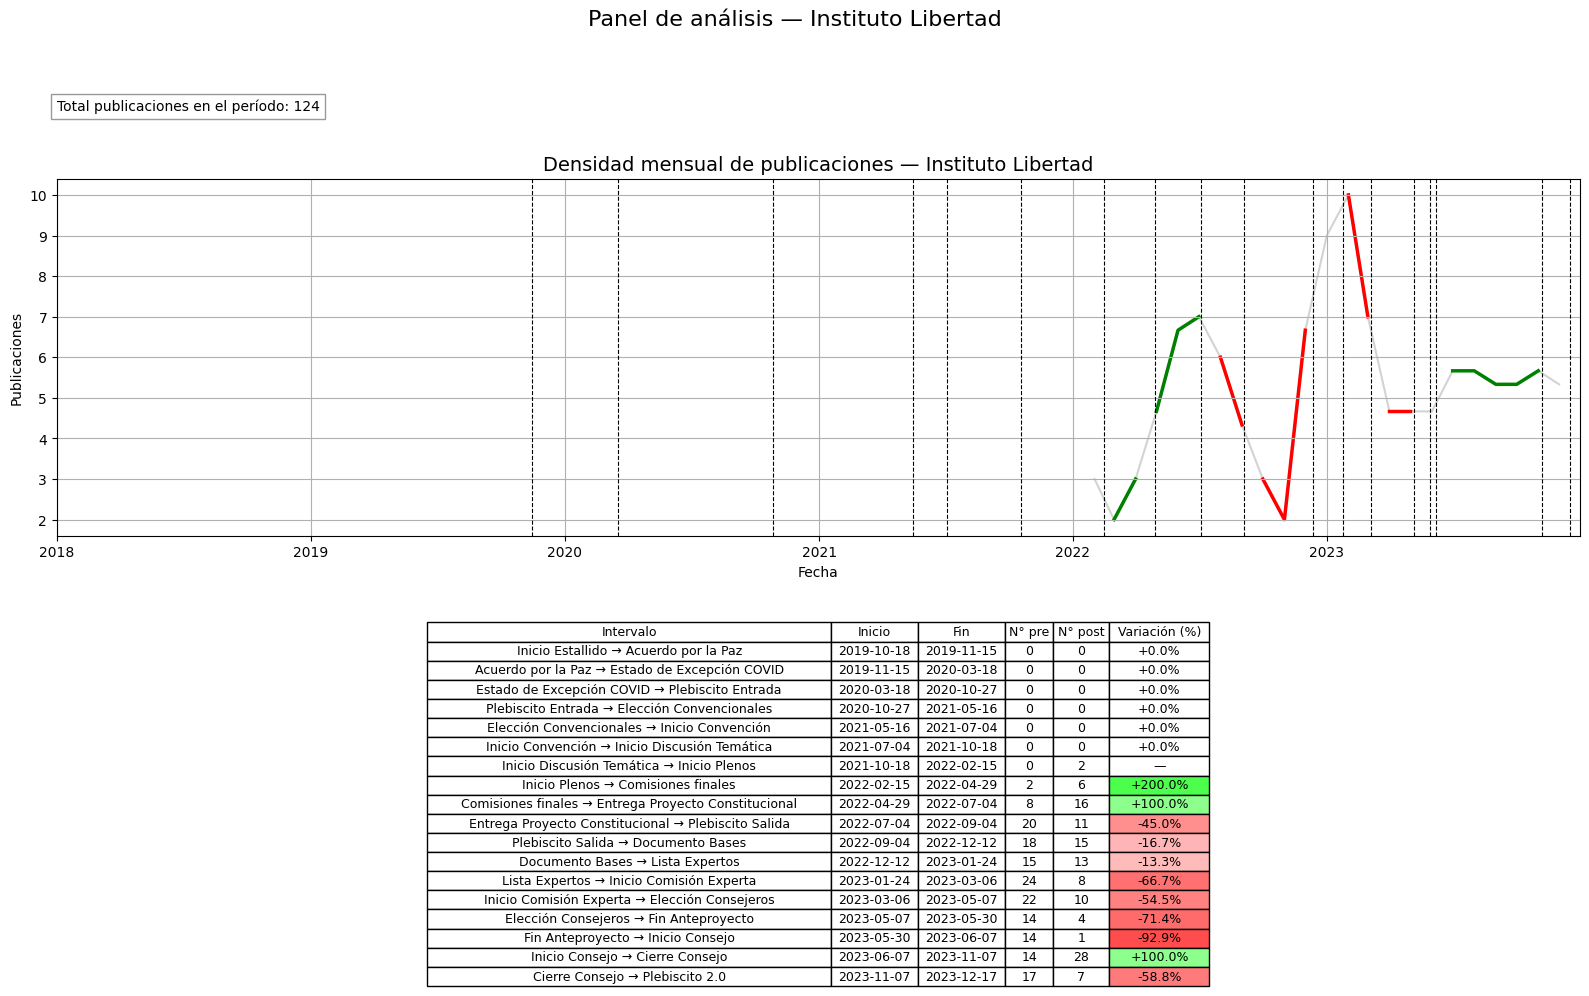


Procesando: Ideas Republicanas


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


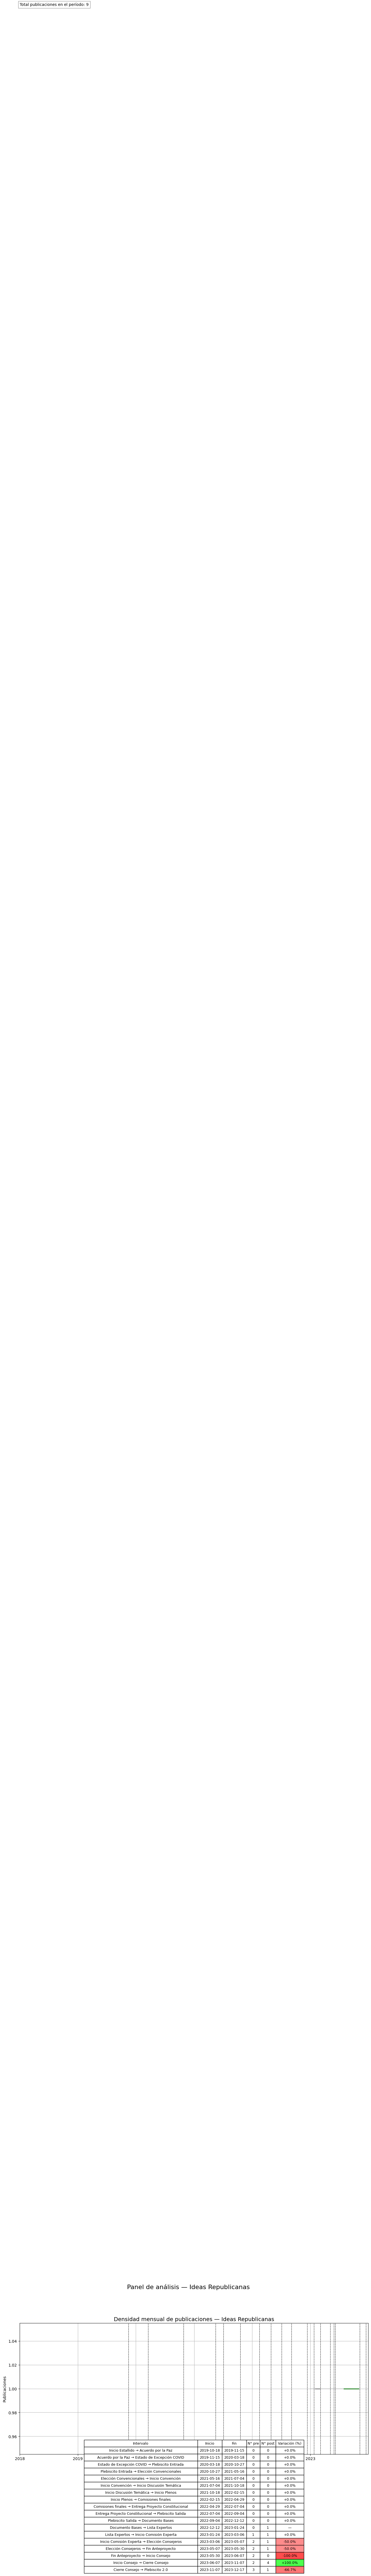


Procesando: Idea País


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


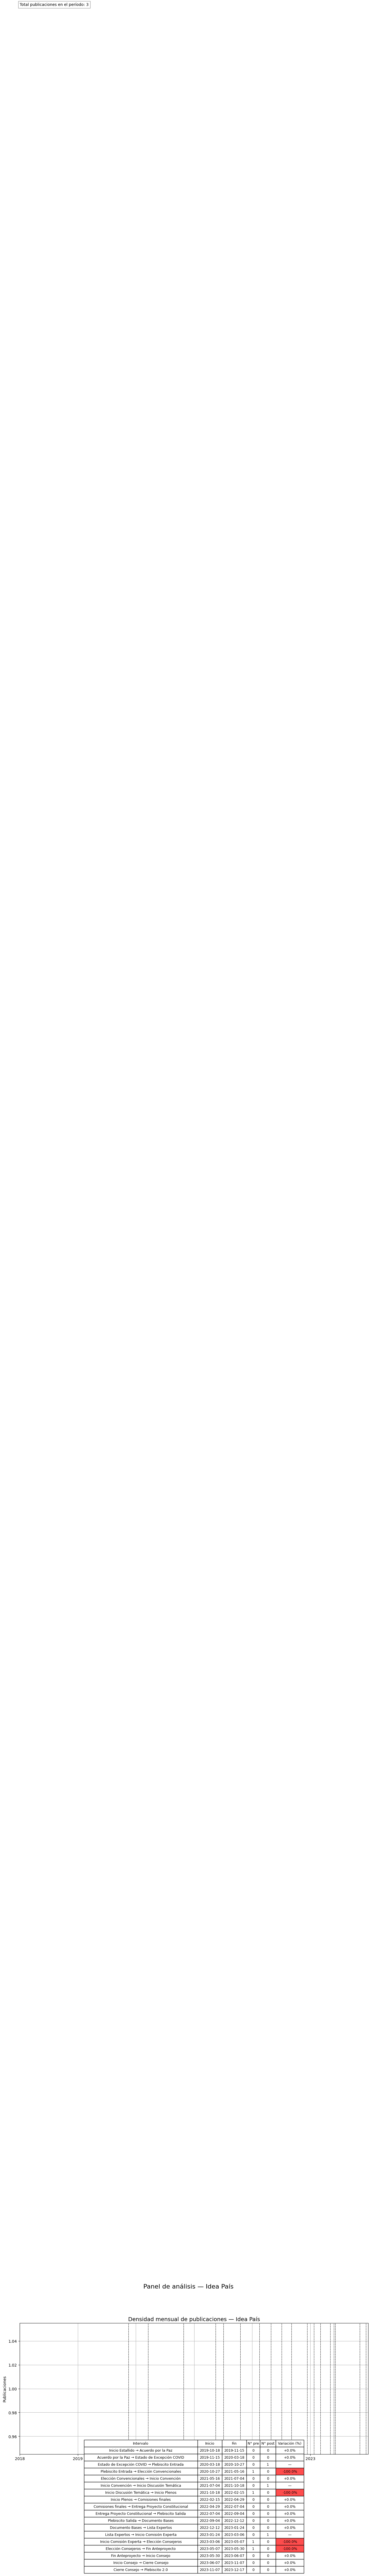


Procesando: Horizontal


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


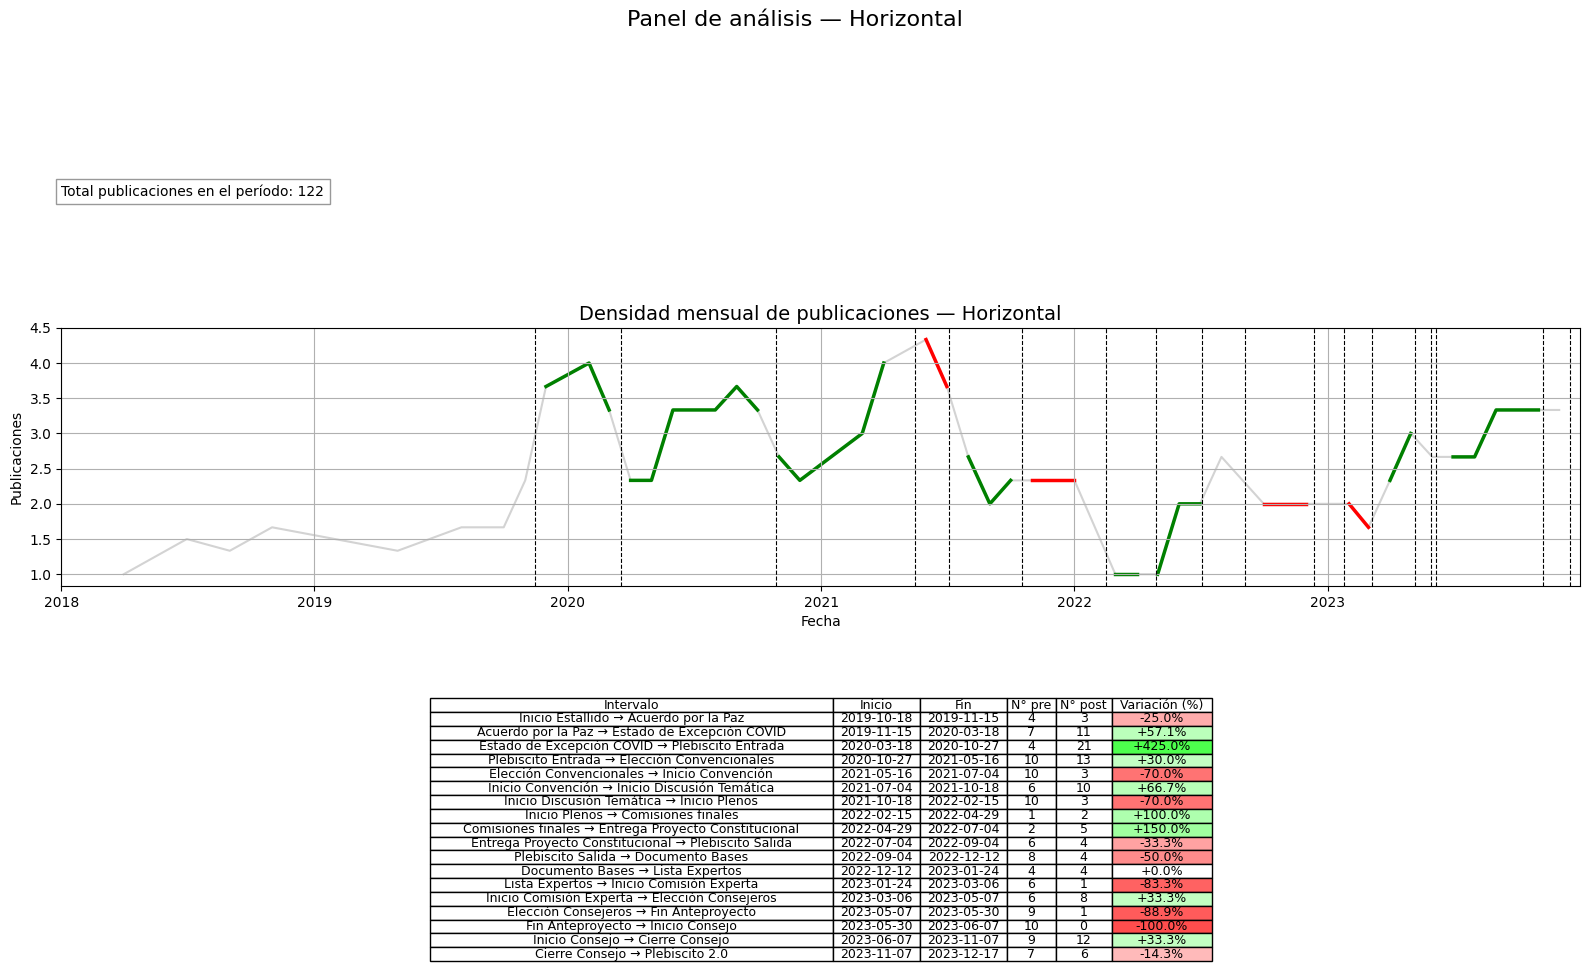


Procesando: Fundación Jaime Guzmán


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


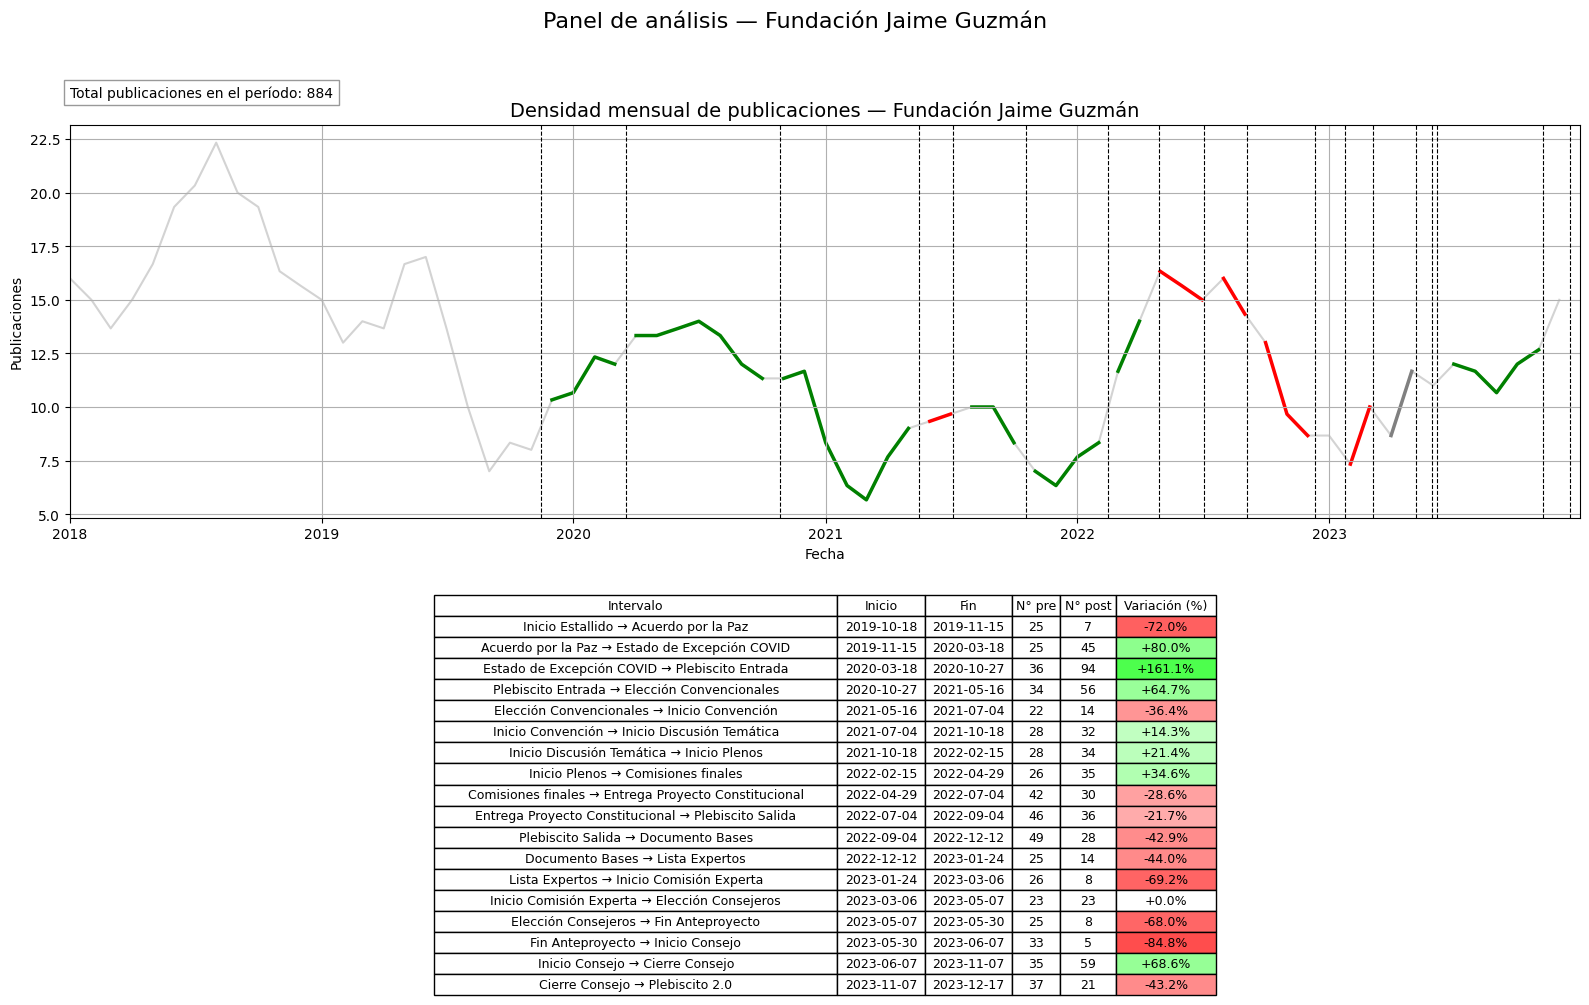


Procesando: CLAPES UC


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


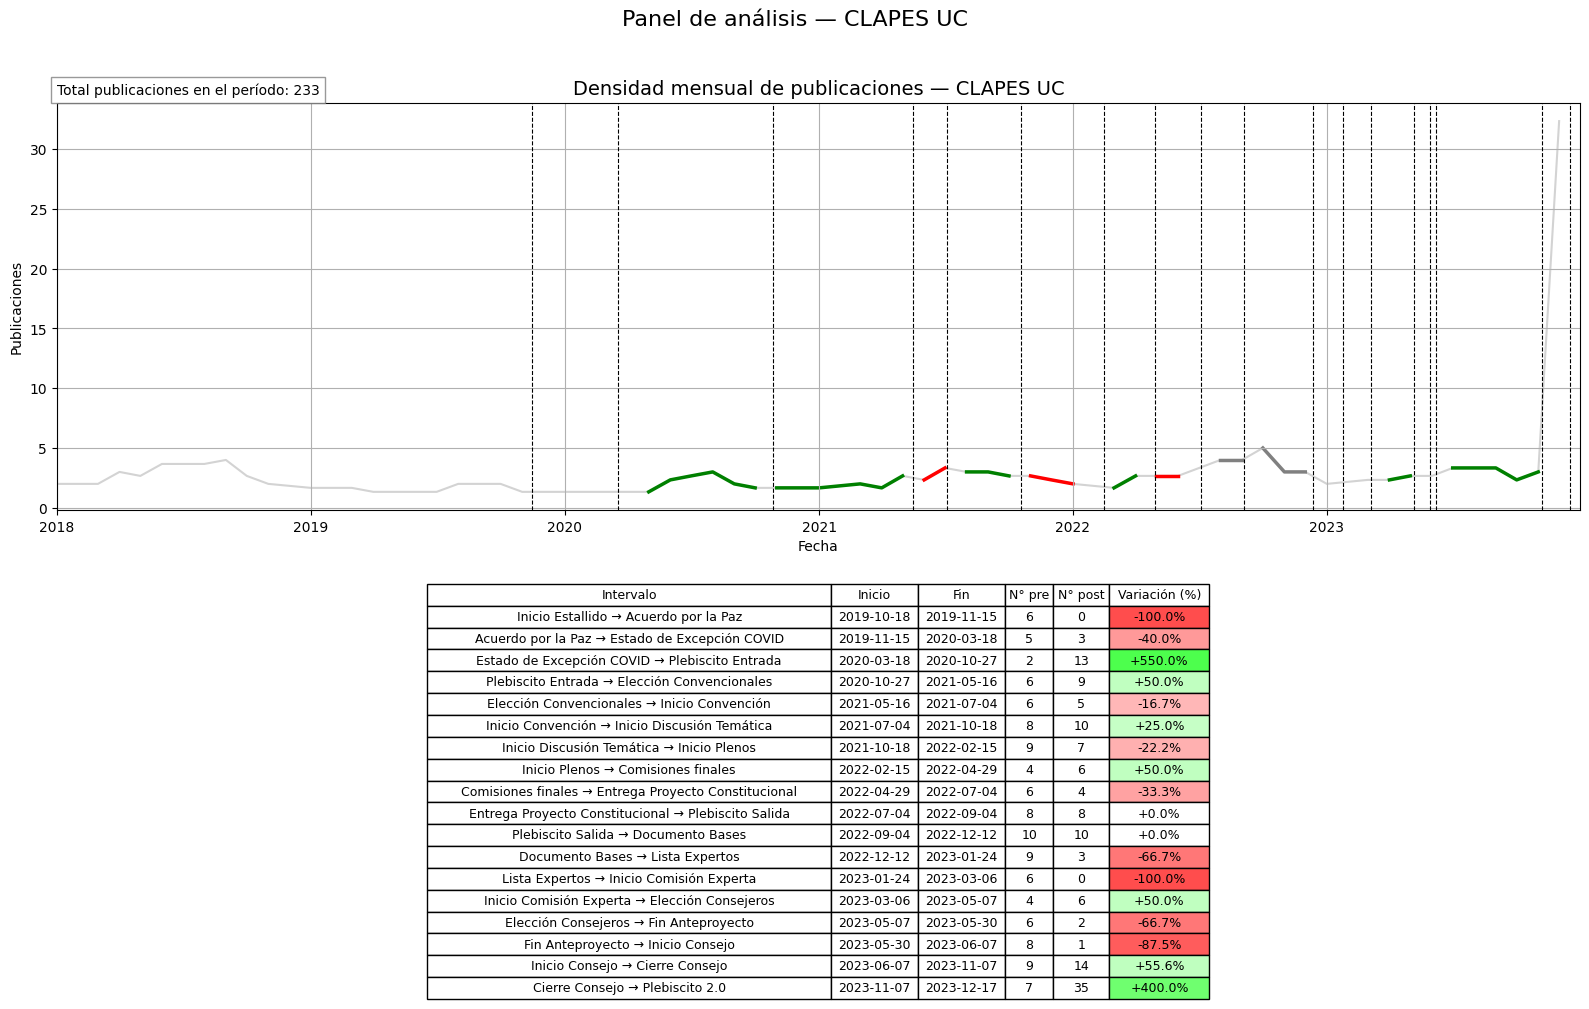


Procesando: FPP


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


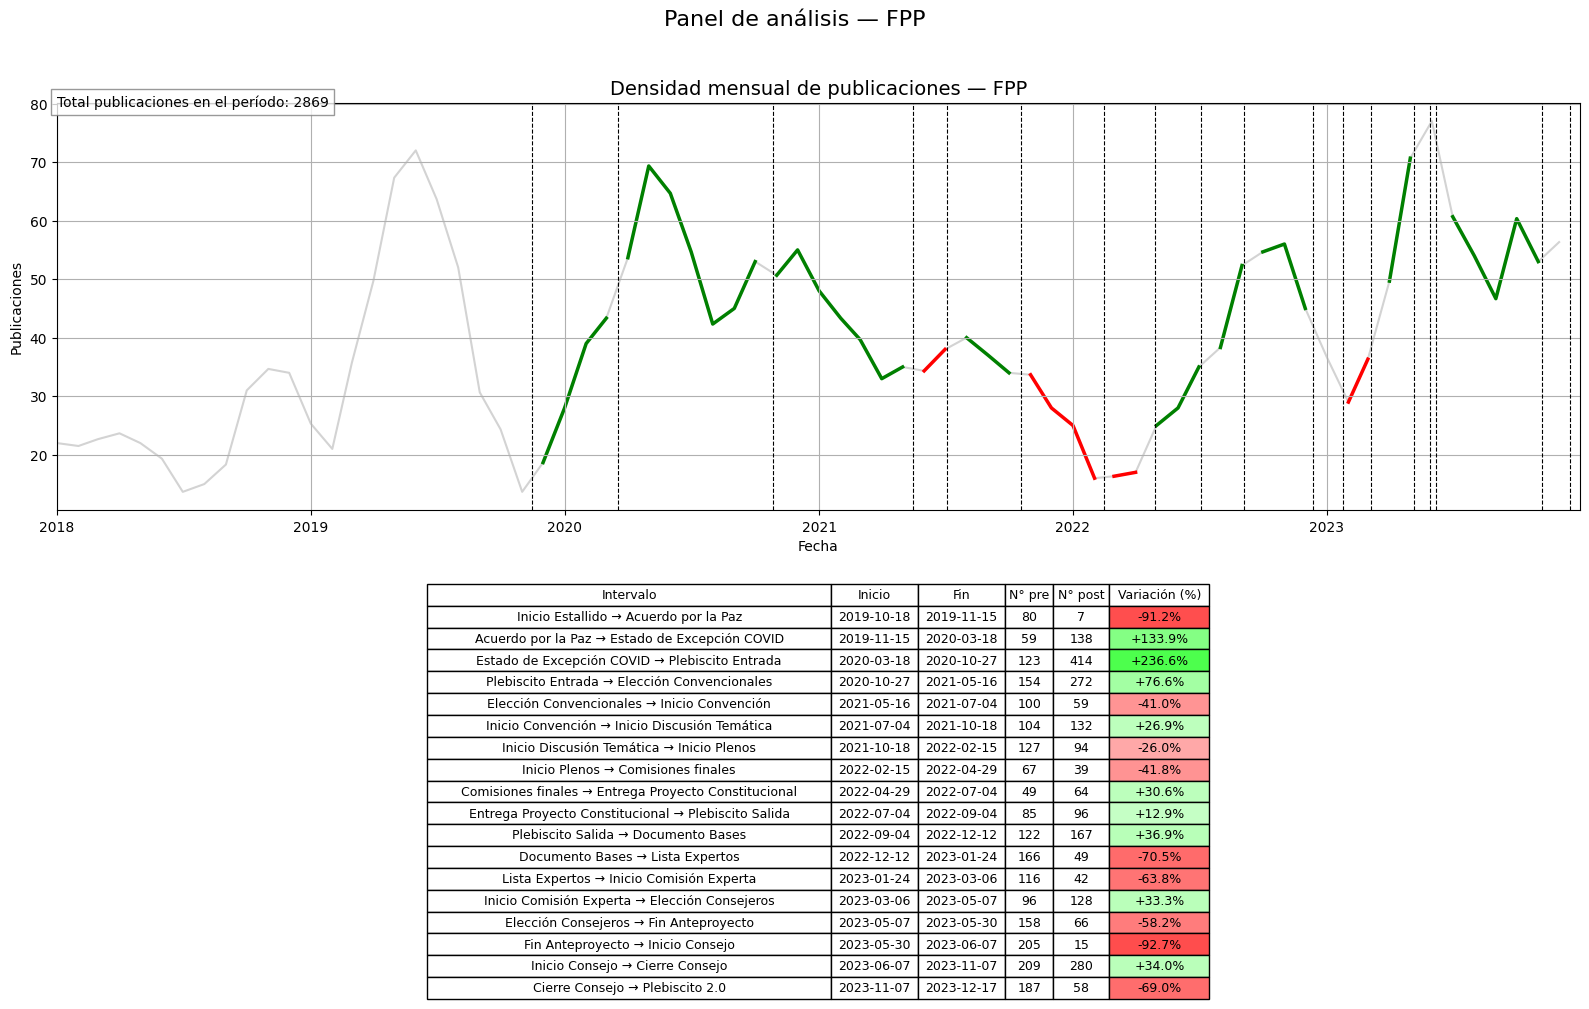

In [12]:
for tt in df_limpio["Think Tank"].unique():
    print(f"\nProcesando: {tt}")

    tabla_tt = construir_tabla_variaciones(df_limpio, think_tank=tt, intervalos=intervalos)
    graficar_panel_completo(df_limpio, think_tank=tt, intervalos=intervalos, tabla_variaciones=tabla_tt)


In [13]:
def procesar_por(df, agrupador_col):
    for valor in df[agrupador_col].dropna().unique():
        print(f"\nProcesando {agrupador_col}: {valor}")

        # Copia limpia del DataFrame
        df_temp = df.copy()

        # Eliminar columna original 'Think Tank' si ya existe para evitar colisión
        if "Think Tank" in df_temp.columns and agrupador_col != "Think Tank":
            df_temp = df_temp.drop(columns=["Think Tank"])

        # Renombrar agrupador a 'Think Tank'
        df_temp = df_temp.rename(columns={agrupador_col: "Think Tank"})

        # Construir tabla y graficar
        tabla_temp = construir_tabla_variaciones(df_temp, think_tank=valor, intervalos=intervalos)
        graficar_panel_completo(df_temp, think_tank=valor, intervalos=intervalos, tabla_variaciones=tabla_temp)



Procesando Tipo de Think Tank: Transversal


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


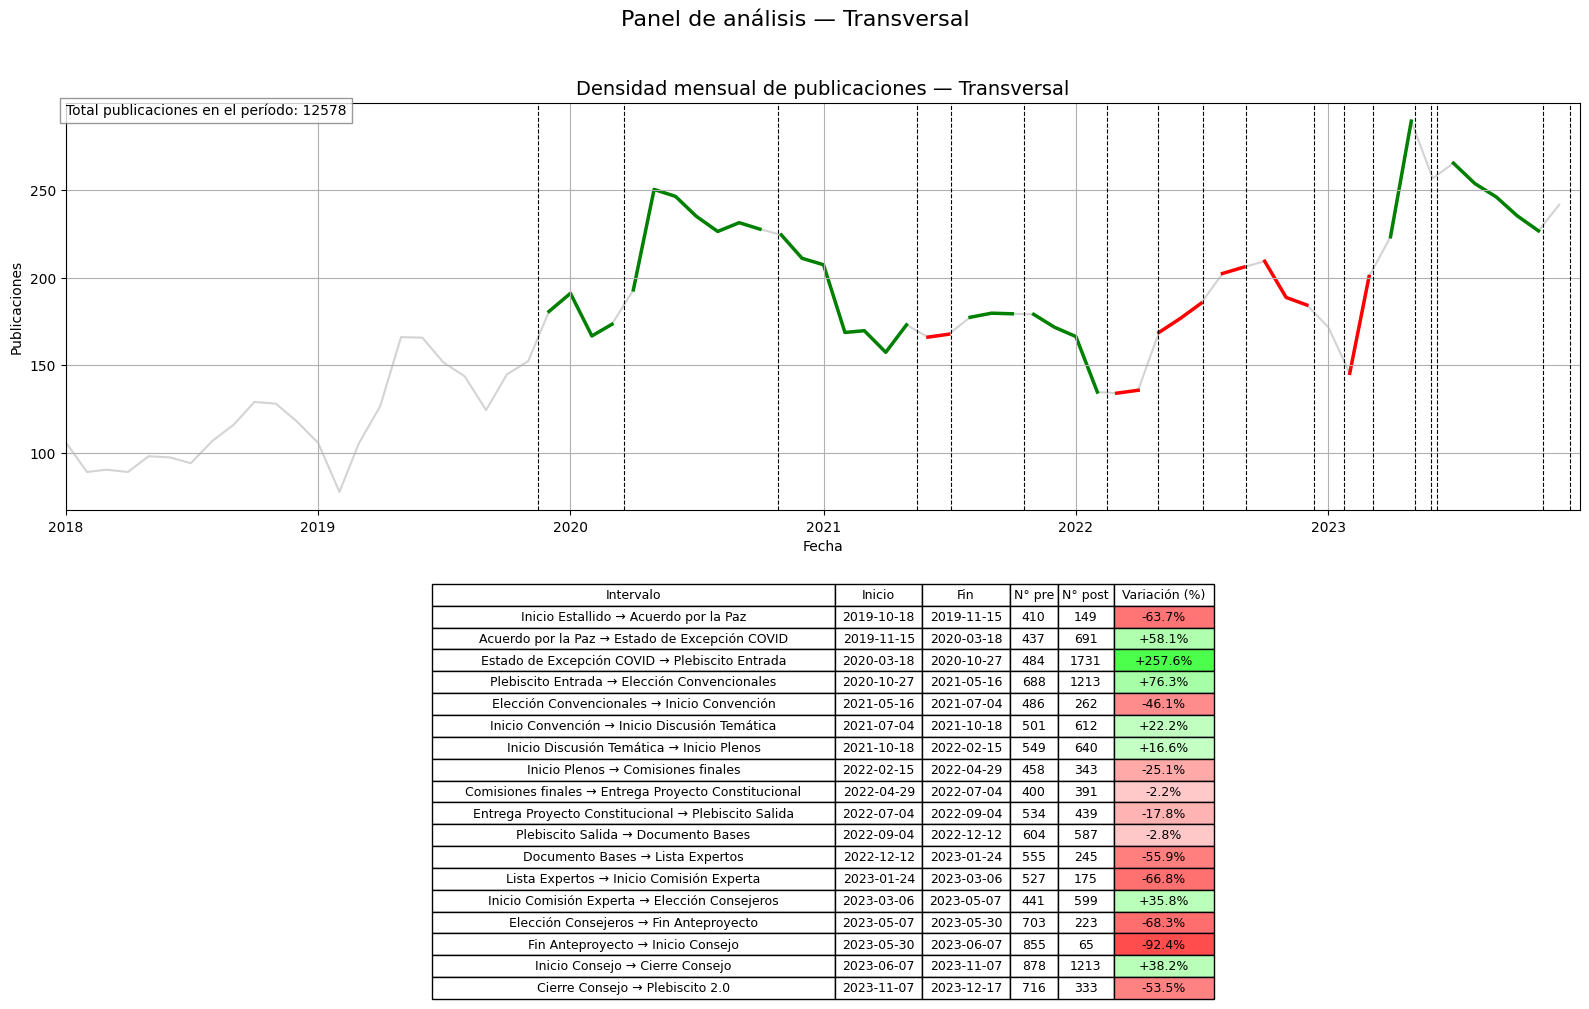


Procesando Tipo de Think Tank: De partido


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


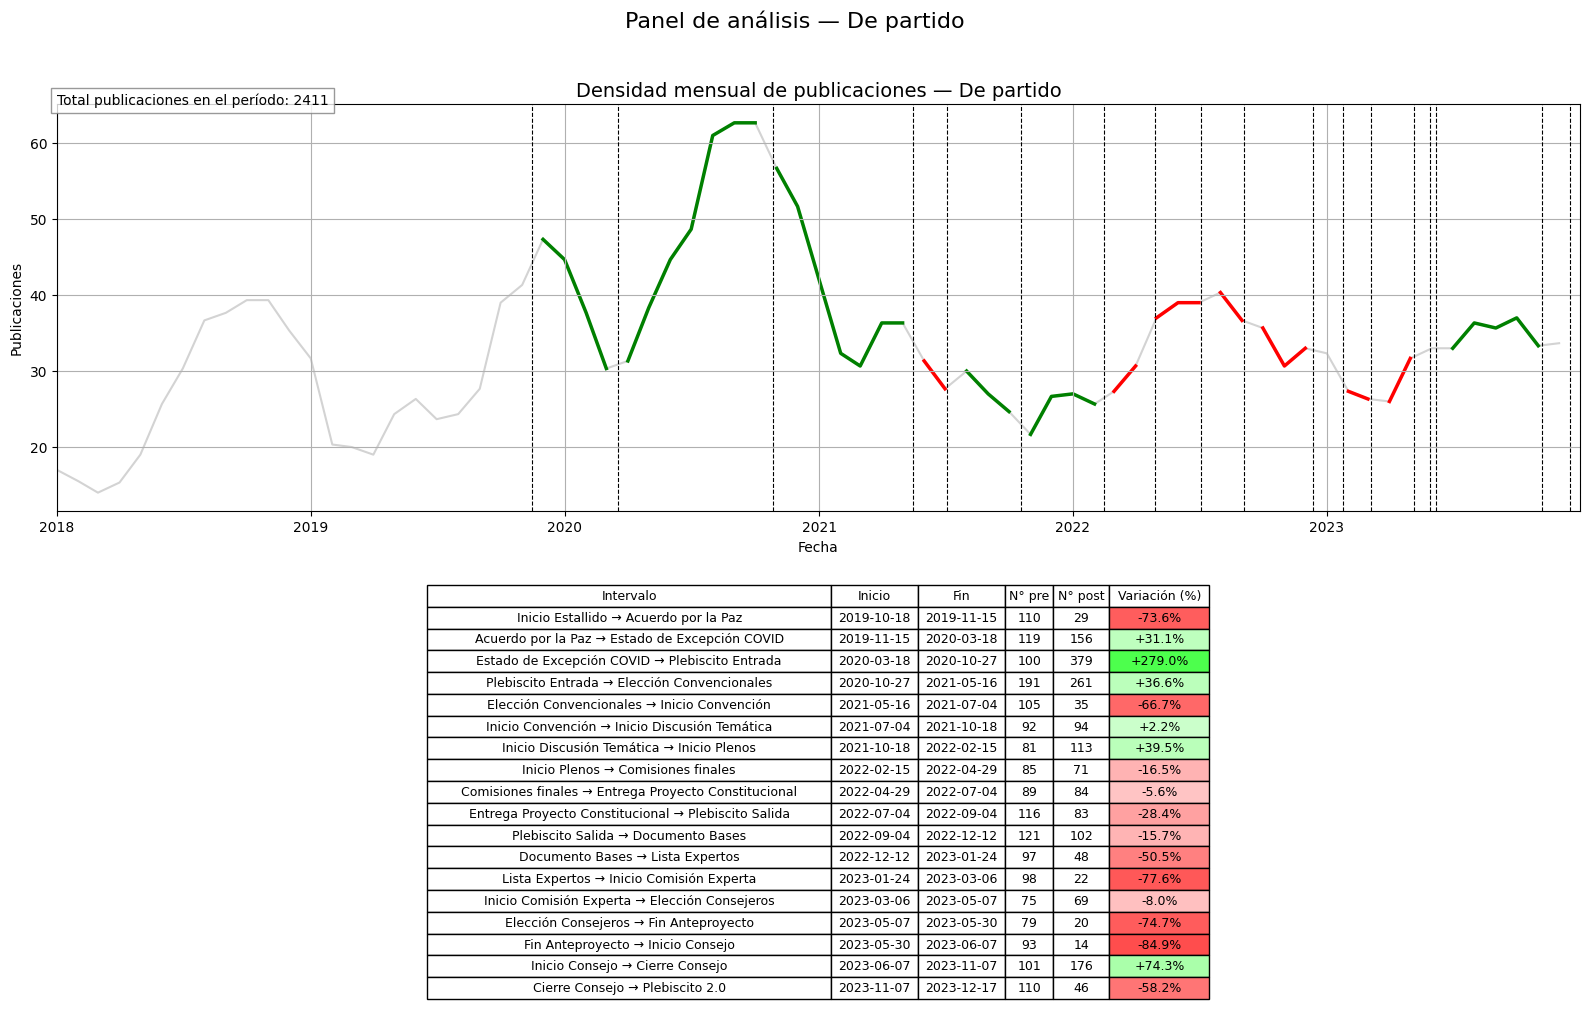


Procesando Tipo de Think Tank: Semi Difuntos


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


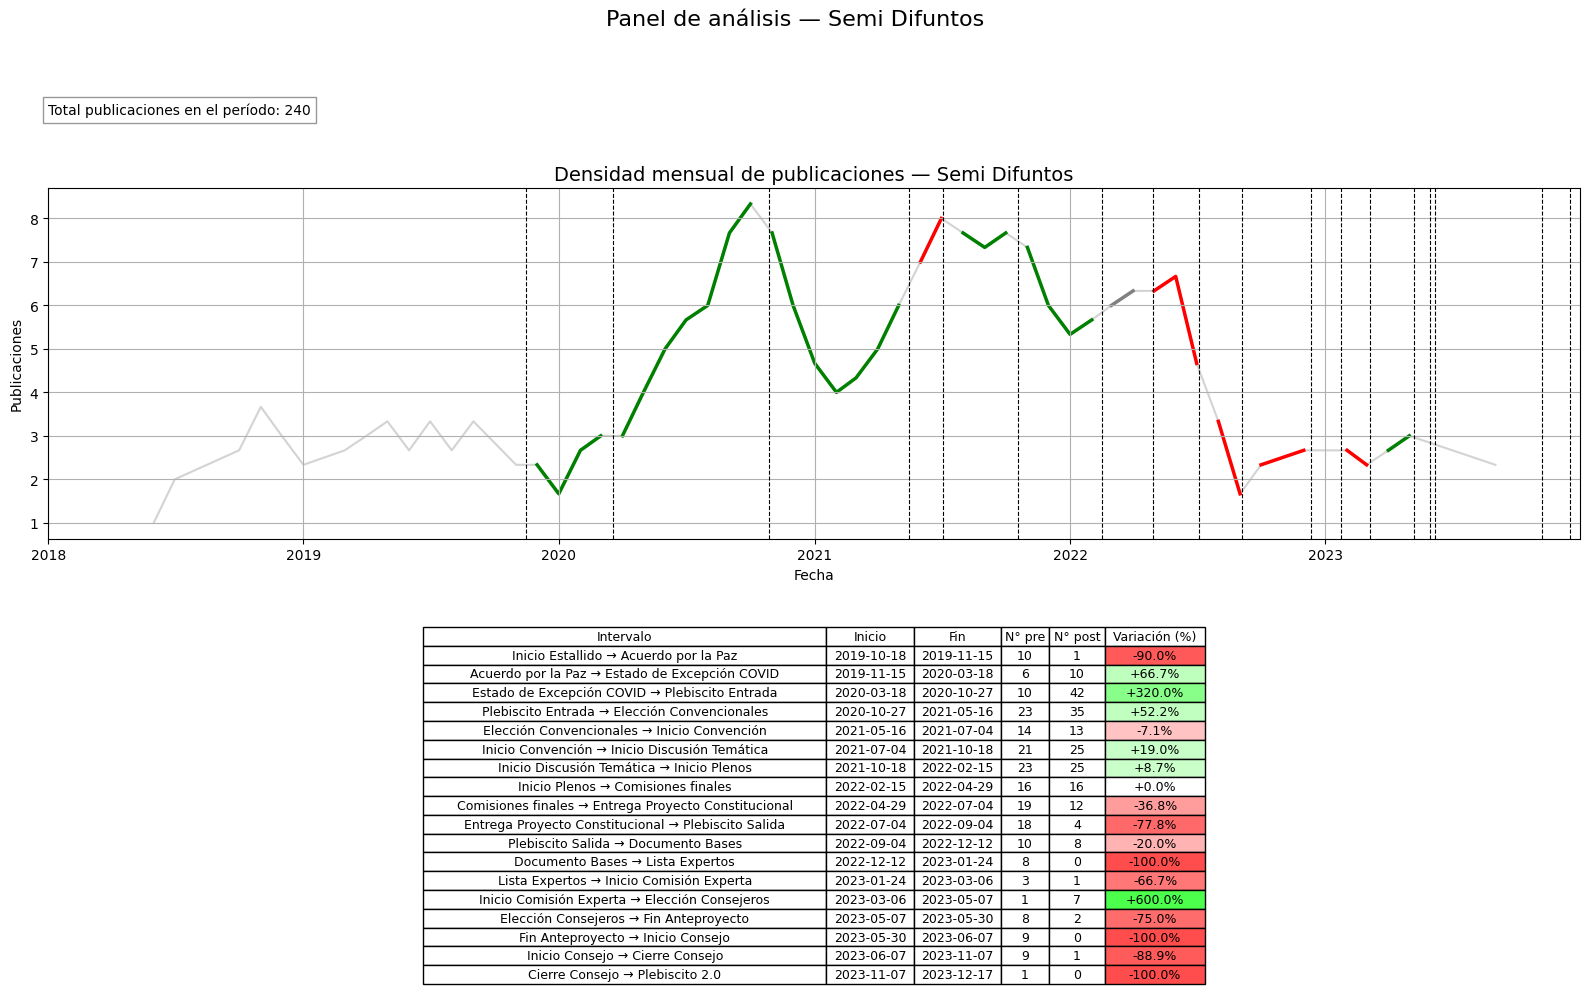


Procesando Tipo de Think Tank: Universidad


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


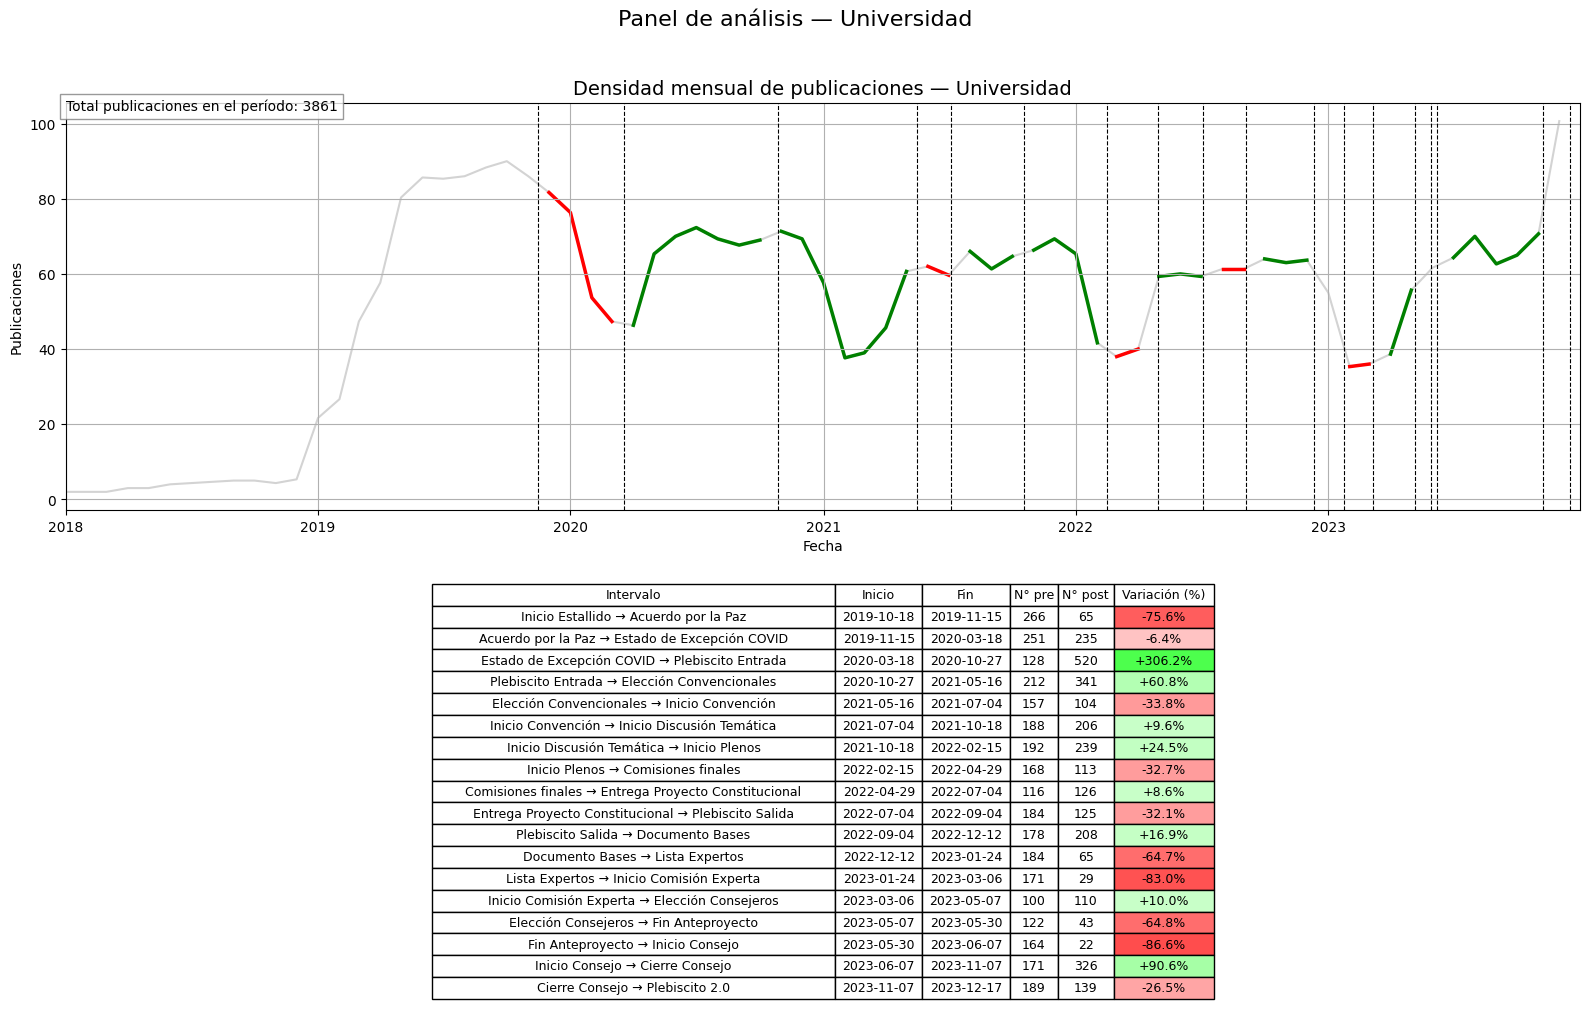

In [14]:
procesar_por(df_limpio, agrupador_col="Tipo de Think Tank")



Procesando Orientación Política: Derecha


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


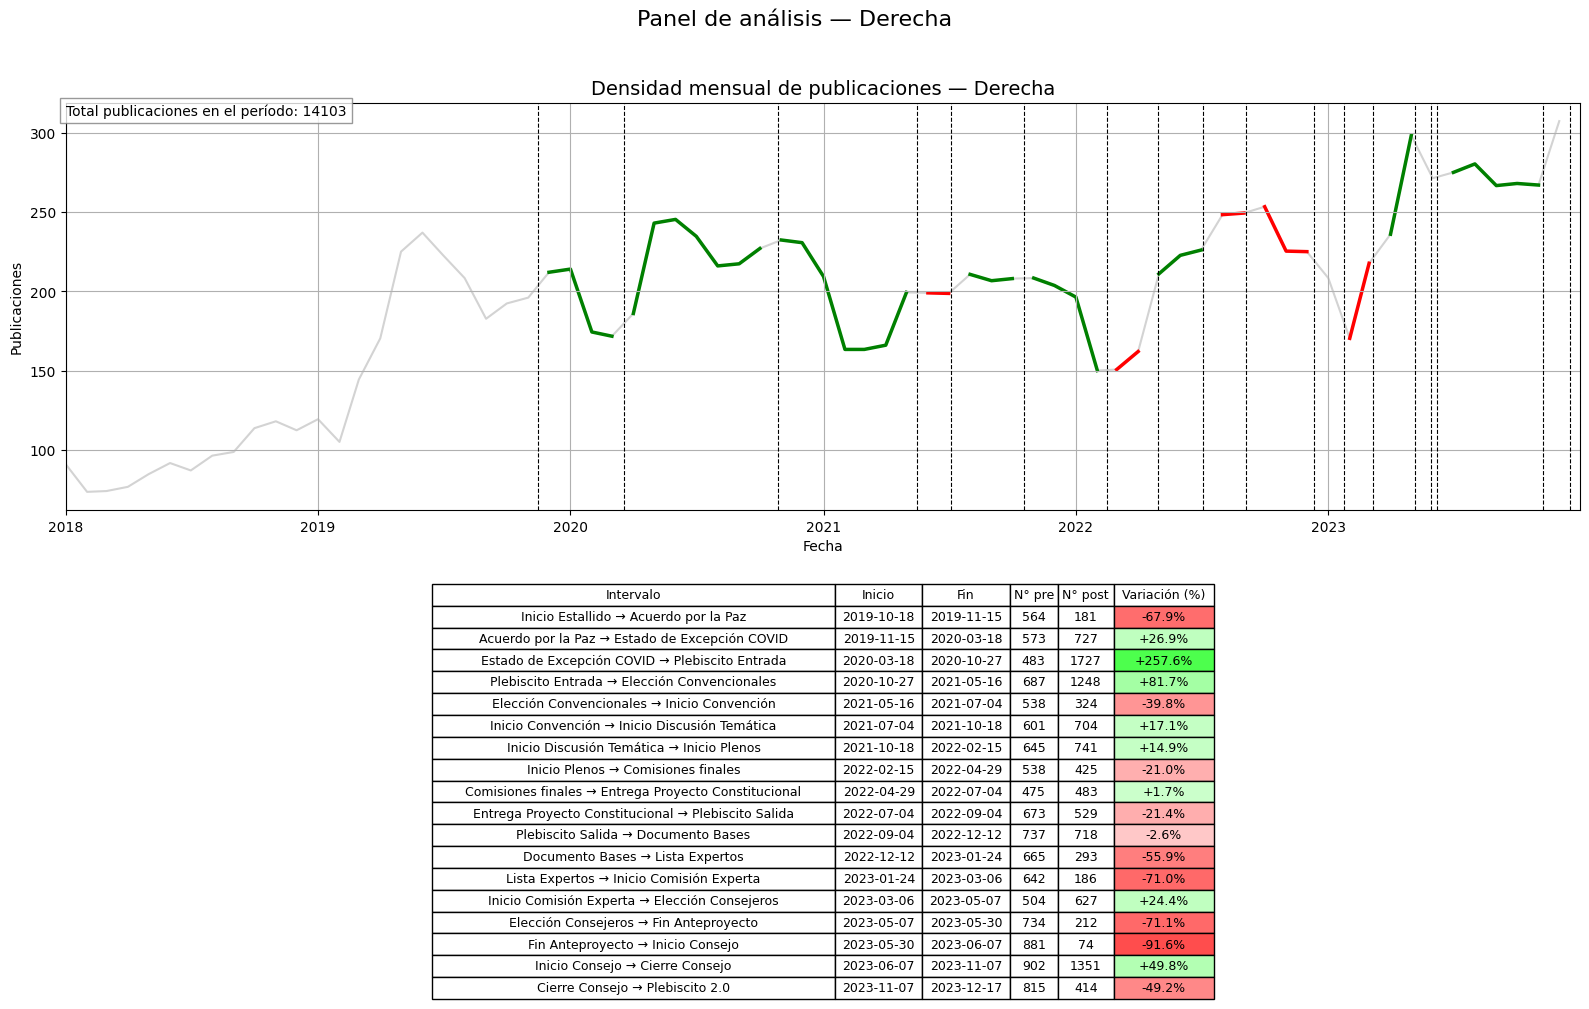


Procesando Orientación Política: Izquierda


C:\Users\rodri\AppData\Local\Temp\ipykernel_27852\1384447930.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


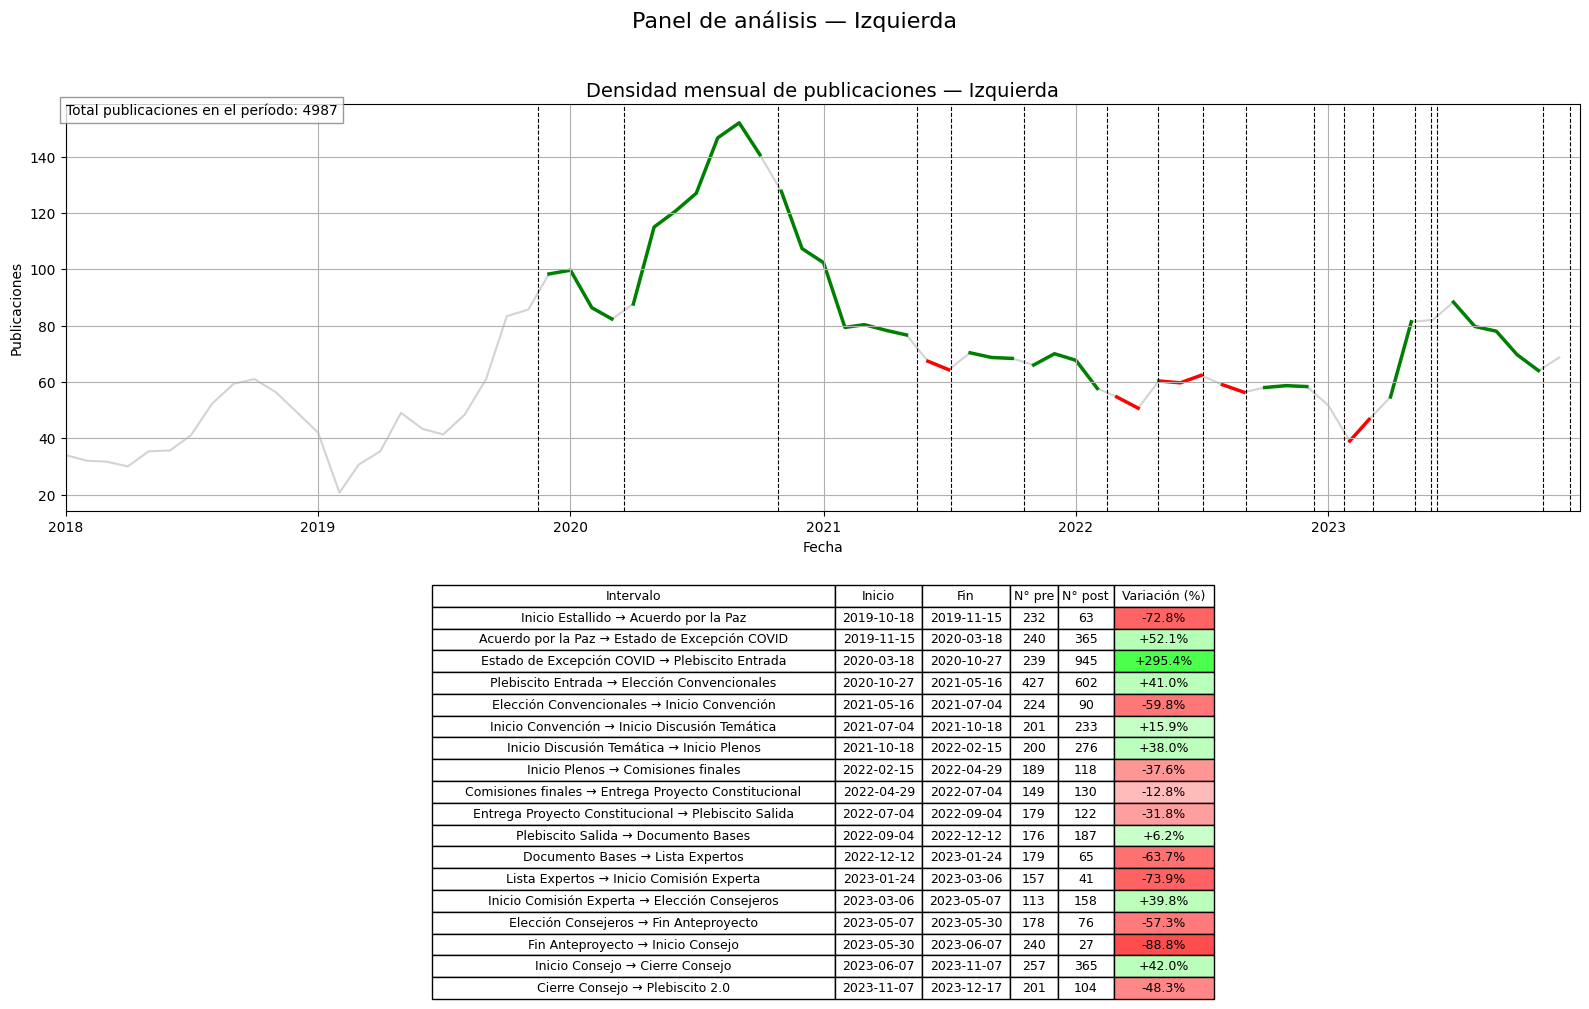

In [15]:
procesar_por(df_limpio, agrupador_col="Orientación Política")
